# Keypoint Feature Pyramid Network 3D Object Detection + Fully Convolutional Network Semantic Segmentation
# RESNET50 backbone
3D Detection Reference: [SFA3D](https://github.com/maudzung/SFA3D) resnet18 implementation on kitti dataset.

In [1]:
!nvcc --version
!nvidia-smi

import torch
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_name(0))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:49:14_PDT_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0
Tue Apr  9 23:14:32 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P8    16W / 115W |     57MiB /  8192MiB |     38%      Default |
|                               |       

# Configuration

## Data Configuration

In [4]:
import math

import numpy as np


CLASS_NAME_TO_ID = {
    'person': 0,
    'trash_bin': 1,
    'chair': 2,
    'pallet_box': 3,
    'table': 4,
    'trash_can': 5,
    'cart': 6,
    'pallet_jack': 7,
    'youbot': 8,
    'rbkairos': 9,
    'p3dx': 10,
    'robotino': 11,
    'p3at': 12,
    'lift': 13
}

colors = [[0, 215, 255], [180,130,70], [237,149,100], [255,191,0],
          [255,144,30], [230,216,173], [235,206,135], [255,105,65],
          [170,205,102], [113,179,60], [170,178,32], [139,139,0],
          [87,139,43], [50,205,50]]

#####################################################################################
boundary = {
    "minX": 0,
    "maxX": 10,
    "minY": -5,
    "maxY": 5,
    "minZ": -0.5, #calcular relativo a cada .bin
    "maxZ": 3
}

bound_size_x = boundary['maxX'] - boundary['minX']
bound_size_y = boundary['maxY'] - boundary['minY']
bound_size_z = boundary['maxZ'] - boundary['minZ']

boundary_back = {
    "minX": -10,
    "maxX": 0,
    "minY": -5,
    "maxY": 5,
    "minZ": 0,
    "maxZ": 3
}

BEV_WIDTH = 608  # across y axis -25m ~ 25m
BEV_HEIGHT = 608  # across x axis 0m ~ 50m
DISCRETIZATION = (boundary["maxX"] - boundary["minX"]) / BEV_HEIGHT

# maximum number of points per voxel
T = 35

# voxel size
vd = 0.1  # z
vh = 0.05  # y
vw = 0.05  # x

# voxel grid
W = math.ceil(bound_size_x / vw)
H = math.ceil(bound_size_y / vh)
D = math.ceil(bound_size_z / vd)

Tr_velo_to_cam = np.array([
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1]
])

R0 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
]) 


P2 = np.array([[537.61, 0.0, 960.0, 0.0],
               [0.0, 537.61, 600.0, 0.0],
               [0.0, 0.0, 1.0, 0.0]
               ])

R0_inv = np.linalg.inv(R0)
Tr_velo_to_cam_inv = np.linalg.inv(Tr_velo_to_cam)
P2_inv = np.linalg.pinv(P2)
#####################################################################################

## Training Configurations

In [5]:
import os

import torch
from easydict import EasyDict as edict

def parse_configs():
    config_dict = {}
    config_dict['seed'] = 2604
    config_dict['saved_fn'] = 'fpn_resnet_50_semseg'
    config_dict['root_dir'] = './'
    
    ####################################################################
    ##############     Model configs            ########################
    ####################################################################
    config_dict['arch'] = 'fpn_resnet_50'
    config_dict['pretrained_path'] = None
    ####################################################################
    ##############     Dataloader and Running configs            #######
    ####################################################################
    config_dict['hflip_prob'] = 0.5
    config_dict['no_val'] = False
    config_dict['num_samples'] = None
    config_dict['num_workers'] = 4
    config_dict['batch_size'] = 4
    config_dict['print_freq'] = 50
    config_dict['tensorboard_freq'] = 50
    config_dict['checkpoint_freq'] = 2
    ####################################################################
    ##############     Training strategy            ####################
    ####################################################################
    config_dict['start_epoch'] = 1
    config_dict['num_epochs'] = 300
    config_dict['lr_type'] = 'cosin'
    config_dict['lr'] = 0.001
    config_dict['minimum_lr'] = 1e-7
    config_dict['momentum'] = 0.949
    config_dict['weight_decay'] = 0
    config_dict['optimizer_type'] = 'adam'
    config_dict['steps'] = [150, 180]

    ####################################################################
    ##############     Loss weight            ##########################
    ####################################################################

    ####################################################################
    ##############     Distributed Data Parallel            ############
    ####################################################################
    config_dict['world_size'] = -1
    config_dict['rank'] = -1
    config_dict['dist_url'] = 'tcp://127.0.0.1:29500'
    config_dict['gpu_idx'] = 0
    config_dict['no_cuda'] = False
    config_dict['multiprocessing_distributed'] = False
    ####################################################################
    ##############     Evaluation configurations     ###################
    ####################################################################
    config_dict['evaluate'] = False
    config_dict['resume_path'] = './checkpoints/fpn_resnet_50_semseg/Model_fpn_resnet_50_semseg_epoch_262.pth'
    config_dict['K'] = 50

    configs = edict(config_dict)

    ####################################################################
    ############## Hardware configurations #############################
    ####################################################################
    configs.device = torch.device('cpu' if configs.no_cuda else 'cuda')
    configs.ngpus_per_node = torch.cuda.device_count()

    configs.pin_memory = True
    configs.input_size = (608, 608)
    configs.hm_size = (152, 152)
    configs.down_ratio = 4
    configs.max_objects = 50

    configs.imagenet_pretrained = True
    configs.head_conv = 64
    configs.num_classes = 14
    configs.num_center_offset = 2
    configs.num_z = 1
    configs.num_dim = 3
    configs.num_direction = 2  # sin, cos

    configs.heads = { 
        'hm_cen': configs.num_classes,
        'cen_offset': configs.num_center_offset,
        'direction': configs.num_direction,
        'z_coor': configs.num_z,
        'dim': configs.num_dim
    }

    configs.num_input_features = 4

    ####################################################################
    ############## Dataset, logs, Checkpoints dir ######################
    ####################################################################
    configs.dataset_dir = os.path.join(configs.root_dir, 'synth_depot_dataset')       
    configs.checkpoints_dir = os.path.join(configs.root_dir, 'checkpoints', configs.saved_fn)
    configs.logs_dir = os.path.join(configs.root_dir, 'logs', configs.saved_fn)

    if not os.path.isdir(configs.checkpoints_dir):
        os.makedirs(configs.checkpoints_dir)
    if not os.path.isdir(configs.logs_dir):
        os.makedirs(configs.logs_dir)

    return configs



# Data Processing


## Transformation Functions

In [6]:
import os
import sys
import math

import numpy as np
import torch

#def angle_in_limit(angle):
    # # To limit the angle in -pi/2 - pi/2
    # limit_degree = 5
    # while angle >= np.pi / 2:
    #     angle -= np.pi
    # while angle < -np.pi / 2:
    #     angle += np.pi
    # if abs(angle + np.pi / 2) < limit_degree / 180 * np.pi:
    #     angle = np.pi / 2
    # return angle


def camera_to_lidar(x, y, z, V2C=None, R0=None, P2=None):
    p = np.array([x, y, z, 1])
    if V2C is None or R0 is None:
        p = np.matmul(R0_inv, p)
        p = np.matmul(Tr_velo_to_cam_inv, p)
    else:
        R0_i = np.zeros((4, 4))
        R0_i[:3, :3] = R0
        R0_i[3, 3] = 1
        p = np.matmul(np.linalg.inv(R0_i), p)
        p = np.matmul(inverse_rigid_trans(V2C), p)
    p = p[0:3]
    return tuple(p)


def lidar_to_camera(x, y, z):
    p = np.array([x, y, z, 1])
    # if V2C is None or R0 is None:
    p = np.matmul(Tr_velo_to_cam, p)
    p = np.matmul(R0, p)
    # else:
    #     p = np.matmul(V2C, p)
    #     p = np.matmul(R0, p)
    p = p[0:3]
    return tuple(p)


def camera_to_lidar_point(points):
    # (N, 3) -> (N, 3)
    N = points.shape[0]
    points = np.hstack([points, np.ones((N, 1))]).T  # (N,4) -> (4,N)

    points = np.matmul(R0_inv, points)
    points = np.matmul(Tr_velo_to_cam_inv, points).T  # (4, N) -> (N, 4)
    points = points[:, 0:3]
    return points.reshape(-1, 3)


def lidar_to_camera_point(points, V2C = None):
    # (N, 3) -> (N, 3)
    N = points.shape[0]
    points = np.hstack([points, np.ones((N, 1))]).T

    if V2C is None or R0 is None:
        points = np.matmul(Tr_velo_to_cam, points)
        points = np.matmul(R0, points).T
    else:
        points = np.matmul(V2C, points)
        points = np.matmul(R0, points).T
    points = points[:, 0:3]
    return points.reshape(-1, 3)


def camera_to_lidar_box(boxes, V2C=None, R0=None, P2=None):
    # (N, 7) -> (N, 7) x,y,z,h,w,l,r
    ret = []
    for box in boxes:
        x, y, z, h, w, l, ry = box
        (x, y, z), h, w, l, rz = camera_to_lidar(x, y, z, V2C=V2C, R0=R0, P2=P2), h, w, l, -ry - np.pi / 2
        # rz = angle_in_limit(rz)
        ret.append([x, y, z, h, w, l, rz])
    return np.array(ret).reshape(-1, 7)


def lidar_to_camera_box(boxes):
    # (N, 7) -> (N, 7) x,y,z,h,w,l,r
    ret = []
    for box in boxes:
        x, y, z, h, w, l, rz = box
        (x, y, z), h, w, l, ry = lidar_to_camera(x, y, z), h, w, l, -rz - np.pi / 2
        # ry = angle_in_limit(ry)
        ret.append([x, y, z, h, w, l, ry])
    return np.array(ret).reshape(-1, 7)


def center_to_corner_box2d(boxes_center, coordinate='lidar'):
    # (N, 5) -> (N, 4, 2)
    N = boxes_center.shape[0]
    boxes3d_center = np.zeros((N, 7))
    boxes3d_center[:, [0, 1, 4, 5, 6]] = boxes_center
    boxes3d_corner = center_to_corner_box3d(boxes3d_center, coordinate=coordinate)

    return boxes3d_corner[:, 0:4, 0:2]


def center_to_corner_box3d(boxes_center, coordinate='lidar'):
    # (N, 7) -> (N, 8, 3)
    N = boxes_center.shape[0]
    ret = np.zeros((N, 8, 3), dtype=np.float32)

    if coordinate == 'camera':
        boxes_center = camera_to_lidar_box(boxes_center)

    for i in range(N):
        box = boxes_center[i]
        translation = box[0:3]
        size = box[3:6]
        rotation = [0, 0, box[-1]]

        h, w, l = size[0], size[1], size[2]
        trackletBox = np.array([  # in velodyne coordinates around zero point and without orientation yet
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2], \
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2], \
            [0, 0, 0, 0, h, h, h, h]])

        # re-create 3D bounding box in velodyne coordinate system
        yaw = rotation[2]
        rotMat = np.array([
            [np.cos(yaw), -np.sin(yaw), 0.0],
            [np.sin(yaw), np.cos(yaw), 0.0],
            [0.0, 0.0, 1.0]])
        cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
        box3d = cornerPosInVelo.transpose()
        ret[i] = box3d

    if coordinate == 'camera':
        for idx in range(len(ret)):
            ret[idx] = lidar_to_camera_point(ret[idx])

    return ret


CORNER2CENTER_AVG = True


def corner_to_center_box3d(boxes_corner, coordinate='camera'):
    # (N, 8, 3) -> (N, 7) x,y,z,h,w,l,ry/z
    if coordinate == 'lidar':
        for idx in range(len(boxes_corner)):
            boxes_corner[idx] = lidar_to_camera_point(boxes_corner[idx])

    ret = []
    for roi in boxes_corner:
        if CORNER2CENTER_AVG:  # average version  
            roi = np.array(roi)
            h = abs(np.sum(roi[:4, 1] - roi[4:, 1]) / 4)
            w = np.sum(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[3, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[1, [0, 2]] - roi[2, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[7, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[5, [0, 2]] - roi[6, [0, 2]]) ** 2))
            ) / 4
            l = np.sum(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[1, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[2, [0, 2]] - roi[3, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[5, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[6, [0, 2]] - roi[7, [0, 2]]) ** 2))
            ) / 4
            x = np.sum(roi[:, 0], axis=0) / 8
            y = np.sum(roi[0:4, 1], axis=0) / 4
            z = np.sum(roi[:, 2], axis=0) / 8
            ry = np.sum(
                math.atan2(roi[2, 0] - roi[1, 0], roi[2, 2] - roi[1, 2]) +
                math.atan2(roi[6, 0] - roi[5, 0], roi[6, 2] - roi[5, 2]) +
                math.atan2(roi[3, 0] - roi[0, 0], roi[3, 2] - roi[0, 2]) +
                math.atan2(roi[7, 0] - roi[4, 0], roi[7, 2] - roi[4, 2]) +
                math.atan2(roi[0, 2] - roi[1, 2], roi[1, 0] - roi[0, 0]) +
                math.atan2(roi[4, 2] - roi[5, 2], roi[5, 0] - roi[4, 0]) +
                math.atan2(roi[3, 2] - roi[2, 2], roi[2, 0] - roi[3, 0]) +
                math.atan2(roi[7, 2] - roi[6, 2], roi[6, 0] - roi[7, 0])
            ) / 8
            if w > l:
                w, l = l, w
                ry = ry - np.pi / 2
            elif l > w:
                l, w = w, l
                ry = ry - np.pi / 2
            ret.append([x, y, z, h, w, l, ry])

        else:  # max version
            h = max(abs(roi[:4, 1] - roi[4:, 1]))
            w = np.max(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[3, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[1, [0, 2]] - roi[2, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[7, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[5, [0, 2]] - roi[6, [0, 2]]) ** 2))
            )
            l = np.max(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[1, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[2, [0, 2]] - roi[3, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[5, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[6, [0, 2]] - roi[7, [0, 2]]) ** 2))
            )
            x = np.sum(roi[:, 0], axis=0) / 8
            y = np.sum(roi[0:4, 1], axis=0) / 4
            z = np.sum(roi[:, 2], axis=0) / 8
            ry = np.sum(
                math.atan2(roi[2, 0] - roi[1, 0], roi[2, 2] - roi[1, 2]) +
                math.atan2(roi[6, 0] - roi[5, 0], roi[6, 2] - roi[5, 2]) +
                math.atan2(roi[3, 0] - roi[0, 0], roi[3, 2] - roi[0, 2]) +
                math.atan2(roi[7, 0] - roi[4, 0], roi[7, 2] - roi[4, 2]) +
                math.atan2(roi[0, 2] - roi[1, 2], roi[1, 0] - roi[0, 0]) +
                math.atan2(roi[4, 2] - roi[5, 2], roi[5, 0] - roi[4, 0]) +
                math.atan2(roi[3, 2] - roi[2, 2], roi[2, 0] - roi[3, 0]) +
                math.atan2(roi[7, 2] - roi[6, 2], roi[6, 0] - roi[7, 0])
            ) / 8
            if w > l:
                w, l = l, w
                ry = angle_in_limit(ry + np.pi / 2)
            ret.append([x, y, z, h, w, l, ry])

    if coordinate == 'lidar':
        ret = camera_to_lidar_box(np.array(ret))

    return np.array(ret)


def point_transform(points, tx, ty, tz, rx=0, ry=0, rz=0):
    # Input:
    #   points: (N, 3)
    #   rx/y/z: in radians
    # Output:
    #   points: (N, 3)
    N = points.shape[0]
    points = np.hstack([points, np.ones((N, 1))])

    mat1 = np.eye(4)
    mat1[3, 0:3] = tx, ty, tz
    points = np.matmul(points, mat1)

    if rx != 0:
        mat = np.zeros((4, 4))
        mat[0, 0] = 1
        mat[3, 3] = 1
        mat[1, 1] = np.cos(rx)
        mat[1, 2] = -np.sin(rx)
        mat[2, 1] = np.sin(rx)
        mat[2, 2] = np.cos(rx)
        points = np.matmul(points, mat)

    if ry != 0:
        mat = np.zeros((4, 4))
        mat[1, 1] = 1
        mat[3, 3] = 1
        mat[0, 0] = np.cos(ry)
        mat[0, 2] = np.sin(ry)
        mat[2, 0] = -np.sin(ry)
        mat[2, 2] = np.cos(ry)
        points = np.matmul(points, mat)

    if rz != 0:
        mat = np.zeros((4, 4))
        mat[2, 2] = 1
        mat[3, 3] = 1
        mat[0, 0] = np.cos(rz)
        mat[0, 1] = -np.sin(rz)
        mat[1, 0] = np.sin(rz)
        mat[1, 1] = np.cos(rz)
        points = np.matmul(points, mat)

    return points[:, 0:3]


def box_transform(boxes, tx, ty, tz, r=0, coordinate='lidar'):
    # Input:
    #   boxes: (N, 7) x y z h w l rz/y
    # Output:
    #   boxes: (N, 7) x y z h w l rz/y
    boxes_corner = center_to_corner_box3d(boxes, coordinate=coordinate)  # (N, 8, 3)
    for idx in range(len(boxes_corner)):
        if coordinate == 'lidar':
            boxes_corner[idx] = point_transform(boxes_corner[idx], tx, ty, tz, rz=r)
        else:
            boxes_corner[idx] = point_transform(boxes_corner[idx], tx, ty, tz, ry=r)

    return corner_to_center_box3d(boxes_corner, coordinate=coordinate)


def inverse_rigid_trans(Tr):
    ''' Inverse a rigid body transform matrix (3x4 as [R|t])
        [R'|-R't; 0|1]
    '''
    inv_Tr = np.zeros_like(Tr)  # 3x4
    inv_Tr[0:3, 0:3] = np.transpose(Tr[0:3, 0:3])
    inv_Tr[0:3, 3] = np.dot(-np.transpose(Tr[0:3, 0:3]), Tr[0:3, 3])
    return inv_Tr


class Compose(object):
    def __init__(self, transforms, p=1.0):
        self.transforms = transforms
        self.p = p

    def __call__(self, lidar, labels, sem_label):
        if np.random.random() <= self.p:
            for t in self.transforms:
                lidar, labels, sem_label = t(lidar, labels, sem_label)
        return lidar, labels, sem_label


class OneOf(object):
    def __init__(self, transforms, p=1.0):
        self.transforms = transforms
        self.p = p

    def __call__(self, lidar, labels, sem_label):
        if np.random.random() <= self.p:
            choice = np.random.randint(low=0, high=len(self.transforms))
            lidar, labels, sem_label= self.transforms[choice](lidar, labels, sem_label)

        return lidar, labels, sem_label


class Random_Rotation(object):
    def __init__(self, limit_angle=np.pi / 6, p=0.5):
        self.limit_angle = limit_angle
        self.p = p

    def __call__(self, lidar, labels, sem_label):
        """
        :param labels: # (N', 7) x, y, z, h, w, l, r
        :return:
        """
        if np.random.random() <= self.p:
            angle = np.random.uniform(-self.limit_angle, self.limit_angle)
            lidar[:, 0:3] = point_transform(lidar[:, 0:3], 0, 0, 0, rz=angle)
            labels[:, 0:3] = point_transform(labels[:, 0:3], 0, 0, 0, rz=angle) #box_transform(labels, 0, 0, 0, r=angle, coordinate='lidar')
            labels[:,6] = labels[:,6] - angle
            rotation_matrix = cv2.getRotationMatrix2D((304,0), (-angle*180/math.pi), 1.0) #ANGLE NEGATIVE?
            sem_label = cv2.warpAffine(sem_label, rotation_matrix, (608, 608))
            #print(angle)

        return lidar, labels, sem_label

class Random_Translation_Y(object):
    def __init__(self, translation_limit=0.5, p=0.5):
        self.translation_limit = translation_limit
        self.p = p

    def __call__(self, lidar, labels, sem_label):
        """
        :param labels: # (N', 7) x, y, z, h, w, l, r
        :return:
        """
        if np.random.random() <= self.p:
            factor = np.random.uniform(-self.translation_limit, self.translation_limit)
            lidar[:, 0] = lidar[:, 0] + factor
            labels[:, 0] = labels[:, 0] + factor #onde é o x?
            translation_matrix = np.array([[1, 0, 0], [0, 1, (factor//(10/608))]])
            sem_label = cv2.warpAffine(sem_label, translation_matrix, (608, 608))
            

        return lidar, labels, sem_label
    
class Random_Scaling(object):
    def __init__(self, scaling_range=(0.95, 1.05), p=0.5):
        self.scaling_range = scaling_range
        self.p = p

    def __call__(self, lidar, labels):
        """
        :param labels: # (N', 7) x, y, z, h, w, l, r
        :return:
        """
        if np.random.random() <= self.p:
            factor = np.random.uniform(self.scaling_range[0], self.scaling_range[1])
            lidar[:, 0:3] = lidar[:, 0:3] * factor
            labels[:, 0:6] = labels[:, 0:6] * factor

        return lidar, labels


class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
        Refer from: https://github.com/uoguelph-mlrg/Cutout/blob/master/util/cutout.py
    """

    def __init__(self, n_holes, ratio, fill_value=0., p=1.0):
        self.n_holes = n_holes
        self.ratio = ratio
        assert 0. <= fill_value <= 1., "the fill value is in a range of 0 to 1"
        self.fill_value = fill_value
        self.p = p

    def __call__(self, img, targets):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        if np.random.random() <= self.p:
            h = img.size(1)
            w = img.size(2)

            h_cutout = int(self.ratio * h)
            w_cutout = int(self.ratio * w)

            for n in range(self.n_holes):
                y = np.random.randint(h)
                x = np.random.randint(w)

                y1 = np.clip(y - h_cutout // 2, 0, h)
                y2 = np.clip(y + h_cutout // 2, 0, h)
                x1 = np.clip(x - w_cutout // 2, 0, w)
                x2 = np.clip(x + w_cutout // 2, 0, w)

                img[:, y1: y2, x1: x2] = self.fill_value  # Zero out the selected area
                # Remove targets that are in the selected area
                keep_target = []
                for target_idx, target in enumerate(targets):
                    _, _, target_x, target_y, target_w, target_l, _, _ = target
                    if (x1 <= target_x * w <= x2) and (y1 <= target_y * h <= y2):
                        continue
                    keep_target.append(target_idx)
                targets = targets[keep_target]

        return img, targets

## Data Utility Functions

In [7]:
from __future__ import print_function
import os
import sys

import numpy as np
import cv2


class Object3d(object):
    ''' 3d object label '''

    def __init__(self, label_file_line):
        data = label_file_line.split(' ')
        data[1:] = [float(x) for x in data[1:]]
        # extract label, truncation, occlusion
        self.type = data[0]  # 'Car', 'Pedestrian', ...
        self.cls_id = self.cls_type_to_id(self.type)
        self.truncation = data[1]  # truncated pixel ratio [0..1]
        self.occlusion = int(data[2])  # 0=visible, 1=partly occluded, 2=fully occluded, 3=unknown
        self.alpha = data[3]  # object observation angle [-pi..pi]

        # extract 2d bounding box in 0-based coordinates
        self.xmin = data[4]  # left
        self.ymin = data[5]  # top
        self.xmax = data[6]  # right
        self.ymax = data[7]  # bottom
        self.box2d = np.array([self.xmin, self.ymin, self.xmax, self.ymax])

        # extract 3d bounding box information
        self.h = data[8]  # box height
        self.w = data[9]  # box width
        self.l = data[10]  # box length (in meters)
        self.t = (data[11], data[12], data[13])  # location (x,y,z) in camera coord.
        self.dis_to_cam = np.linalg.norm(self.t)
        self.ry = data[14]  # yaw angle (around Y-axis in camera coordinates) [-pi..pi]
        self.score = data[15] if data.__len__() == 16 else -1.0
        self.level_str = None
        self.level = self.get_obj_level()

    def cls_type_to_id(self, cls_type):
        if cls_type not in CLASS_NAME_TO_ID.keys():
            return -1

        return CLASS_NAME_TO_ID[cls_type]

    def get_obj_level(self):
        height = float(self.box2d[3]) - float(self.box2d[1]) + 1

        if height >= 40 and self.truncation <= 0.15 and self.occlusion <= 0:
            self.level_str = 'Easy'
            return 1  # Easy
        elif height >= 25 and self.truncation <= 0.3 and self.occlusion <= 1:
            self.level_str = 'Moderate'
            return 2  # Moderate
        elif height >= 25 and self.truncation <= 0.5 and self.occlusion <= 2:
            self.level_str = 'Hard'
            return 3  # Hard
        else:
            self.level_str = 'UnKnown'
            return 4



def read_label(label_filename):
    lines = [line.rstrip() for line in open(label_filename)]
    objects = [Object3d(line) for line in lines]
    return objects


# class Calibration(object):
    ''' Calibration matrices and utils
        3d XYZ in <label>.txt are in rect camera coord.
        2d box xy are in image2 coord
        Points in <lidar>.bin are in Velodyne coord.
        y_image2 = P^2_rect * x_rect
        y_image2 = P^2_rect * R0_rect * Tr_velo_to_cam * x_velo
        x_ref = Tr_velo_to_cam * x_velo
        x_rect = R0_rect * x_ref
        P^2_rect = [f^2_u,  0,      c^2_u,  -f^2_u b^2_x;
                    0,      f^2_v,  c^2_v,  -f^2_v b^2_y;
                    0,      0,      1,      0]
                 = K * [1|t]
        image2 coord:
         ----> x-axis (u)
        |
        |
        v y-axis (v)
        velodyne coord:
        front x, left y, up z
        rect/ref camera coord:
        right x, down y, front z
        Ref (KITTI paper): http://www.cvlibs.net/publications/Geiger2013IJRR.pdf
        TODO(rqi): do matrix multiplication only once for each projection.
    '''

    def __init__(self, calib_filepath):
        calibs = self.read_calib_file(calib_filepath)
        # Projection matrix from rect camera coord to image2 coord
        self.P2 = calibs['P2']
        self.P2 = np.reshape(self.P2, [3, 4])
        self.P3 = calibs['P3']
        self.P3 = np.reshape(self.P3, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        self.V2C = calibs['Tr_velo2cam']
        self.V2C = np.reshape(self.V2C, [3, 4])
        # Rotation from reference camera coord to rect camera coord
        self.R0 = calibs['R_rect']
        self.R0 = np.reshape(self.R0, [3, 3])

        # Camera intrinsics and extrinsics
        self.c_u = self.P2[0, 2]
        self.c_v = self.P2[1, 2]
        self.f_u = self.P2[0, 0]
        self.f_v = self.P2[1, 1]
        self.b_x = self.P2[0, 3] / (-self.f_u)  # relative
        self.b_y = self.P2[1, 3] / (-self.f_v)

    def read_calib_file(self, filepath):
        with open(filepath) as f:
            lines = f.readlines()

        obj = lines[2].strip().split(' ')[1:]
        P2 = np.array(obj, dtype=np.float32)
        obj = lines[3].strip().split(' ')[1:]
        P3 = np.array(obj, dtype=np.float32)
        obj = lines[4].strip().split(' ')[1:]
        R0 = np.array(obj, dtype=np.float32)
        obj = lines[5].strip().split(' ')[1:]
        Tr_velo_to_cam = np.array(obj, dtype=np.float32)

        return {'P2': P2.reshape(3, 4),
                'P3': P3.reshape(3, 4),
                'R_rect': R0.reshape(3, 3),
                'Tr_velo2cam': Tr_velo_to_cam.reshape(3, 4)}

    def cart2hom(self, pts_3d):
        """
        :param pts: (N, 3 or 2)
        :return pts_hom: (N, 4 or 3)
        """
        pts_hom = np.hstack((pts_3d, np.ones((pts_3d.shape[0], 1), dtype=np.float32)))
        return pts_hom


def compute_radius(det_size, min_overlap=0.7):
    height, width = det_size

    a1 = 1
    b1 = (height + width)
    c1 = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1 = (b1 + sq1) / 2

    a2 = 4
    b2 = 2 * (height + width)
    c2 = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2 = (b2 + sq2) / 2

    a3 = 4 * min_overlap
    b3 = -2 * min_overlap * (height + width)
    c3 = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3 = (b3 + sq3) / 2

    return min(r1, r2, r3)


def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0

    return h


def gen_hm_radius(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)

    return heatmap

def get_filtered_lidar_2(lidar, boundary, labels=None):
    minX = boundary['minX']
    maxX = boundary['maxX']
    minY = boundary['minY']
    maxY = boundary['maxY']
    minZ = 0.0
    maxZ = 3.0

    # Remove the point out of range x,y,z
    mask = np.where((lidar[:, 0] >= minX) & (lidar[:, 0] <= maxX) &
                    (lidar[:, 1] >= minY) & (lidar[:, 1] <= maxY) &
                    (lidar[:, 2] >= minZ) & (lidar[:, 2] <= maxZ))
    lidar = lidar[mask]

    if labels is not None:
        label_x = (labels[:, 1] >= minX) & (labels[:, 1] < maxX)
        label_y = (labels[:, 2] >= minY) & (labels[:, 2] < maxY)
        label_z = (labels[:, 3] >= minZ) & (labels[:, 3] < maxZ)
        mask_label = label_x & label_y & label_z
        labels = labels[mask_label]
        return lidar, labels
    else:
        return lidar

# get min z from data, max z = min z + 3
def get_filtered_lidar(lidar, boundary, labels=None):
    minX = boundary['minX']
    maxX = boundary['maxX']
    minY = boundary['minY']
    maxY = boundary['maxY']
    minZ = np.min(lidar[:,2])
    maxZ = minZ + 3
    
    # Remove the point out of range x,y,z
    mask = np.where((lidar[:, 0] >= minX) & (lidar[:, 0] <= maxX) &
                    (lidar[:, 1] >= minY) & (lidar[:, 1] <= maxY) &
                    (lidar[:, 2] >= minZ) & (lidar[:, 2] <= maxZ))
    lidar = lidar[mask]
    lidar[:, 2] = lidar[:, 2] - minZ

    if labels is not None:
        label_x = (labels[:, 1] >= minX) & (labels[:, 1] < maxX)
        label_y = (labels[:, 2] >= minY) & (labels[:, 2] < maxY)
        label_z = (labels[:, 3] >= minZ) & (labels[:, 3] < maxZ)
        mask_label = label_x & label_y & label_z
        labels = labels[mask_label]
        return lidar, labels
    else:
        return lidar


def box3d_corners_to_center(box3d_corner):
    # (N, 8, 3) -> (N, 7)
    assert box3d_corner.ndim == 3

    xyz = np.mean(box3d_corner, axis=1)

    h = abs(np.mean(box3d_corner[:, 4:, 2] - box3d_corner[:, :4, 2], axis=1, keepdims=True))
    w = (np.sqrt(np.sum((box3d_corner[:, 0, [0, 1]] - box3d_corner[:, 1, [0, 1]]) ** 2, axis=1, keepdims=True)) +
         np.sqrt(np.sum((box3d_corner[:, 2, [0, 1]] - box3d_corner[:, 3, [0, 1]]) ** 2, axis=1, keepdims=True)) +
         np.sqrt(np.sum((box3d_corner[:, 4, [0, 1]] - box3d_corner[:, 5, [0, 1]]) ** 2, axis=1, keepdims=True)) +
         np.sqrt(np.sum((box3d_corner[:, 6, [0, 1]] - box3d_corner[:, 7, [0, 1]]) ** 2, axis=1, keepdims=True))) / 4

    l = (np.sqrt(np.sum((box3d_corner[:, 0, [0, 1]] - box3d_corner[:, 3, [0, 1]]) ** 2, axis=1, keepdims=True)) +
         np.sqrt(np.sum((box3d_corner[:, 1, [0, 1]] - box3d_corner[:, 2, [0, 1]]) ** 2, axis=1, keepdims=True)) +
         np.sqrt(np.sum((box3d_corner[:, 4, [0, 1]] - box3d_corner[:, 7, [0, 1]]) ** 2, axis=1, keepdims=True)) +
         np.sqrt(np.sum((box3d_corner[:, 5, [0, 1]] - box3d_corner[:, 6, [0, 1]]) ** 2, axis=1, keepdims=True))) / 4

    yaw = (np.arctan2(box3d_corner[:, 2, 1] - box3d_corner[:, 1, 1],
                      box3d_corner[:, 2, 0] - box3d_corner[:, 1, 0]) +
           np.arctan2(box3d_corner[:, 3, 1] - box3d_corner[:, 0, 1],
                      box3d_corner[:, 3, 0] - box3d_corner[:, 0, 0]) +
           np.arctan2(box3d_corner[:, 2, 0] - box3d_corner[:, 3, 0],
                      box3d_corner[:, 3, 1] - box3d_corner[:, 2, 1]) +
           np.arctan2(box3d_corner[:, 1, 0] - box3d_corner[:, 0, 0],
                      box3d_corner[:, 0, 1] - box3d_corner[:, 1, 1]))[:, np.newaxis] / 4

    return np.concatenate([h, w, l, xyz, yaw], axis=1).reshape(-1, 7)


def box3d_center_to_conners(box3d_center):
    h, w, l, x, y, z, yaw = box3d_center
    Box = np.array([[-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
                    [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
                    [0, 0, 0, 0, h, h, h, h]])

    rotMat = np.array([
        [np.cos(yaw), -np.sin(yaw), 0.0],
        [np.sin(yaw), np.cos(yaw), 0.0],
        [0.0, 0.0, 1.0]])

    velo_box = np.dot(rotMat, Box)
    cornerPosInVelo = velo_box + np.tile(np.array([x, y, z]), (8, 1)).T
    box3d_corner = cornerPosInVelo.transpose()

    return box3d_corner.astype(np.float32)

## Birds Eye View Utility Functions

In [8]:
import math
import os
import sys

import cv2
import numpy as np


def makeBEVMap(PointCloud_, boundary):
    Height = BEV_HEIGHT + 1
    Width = BEV_WIDTH + 1

    # Discretize Feature Map
    PointCloud = np.copy(PointCloud_)
    PointCloud[:, 0] = np.int_(np.floor(PointCloud[:, 0] / DISCRETIZATION))
    PointCloud[:, 1] = np.int_(np.floor(PointCloud[:, 1] / DISCRETIZATION) + Width / 2)

    # sort-3times
    sorted_indices = np.lexsort((-PointCloud[:, 2], PointCloud[:, 1], PointCloud[:, 0]))
    PointCloud = PointCloud[sorted_indices]
    _, unique_indices, unique_counts = np.unique(PointCloud[:, 0:2], axis=0, return_index=True, return_counts=True)
    PointCloud_top = PointCloud[unique_indices]

    # Height Map, Intensity Map & Density Map
    heightMap = np.zeros((Height, Width))
    intensityMap = np.zeros((Height, Width))
    densityMap = np.zeros((Height, Width))

    # some important problem is image coordinate is (y,x), not (x,y)
    max_height = float(np.abs(boundary['maxZ'] - boundary['minZ']))
    heightMap[np.int_(PointCloud_top[:, 0]), np.int_(PointCloud_top[:, 1])] = PointCloud_top[:, 2] / max_height

    normalizedCounts = np.minimum(1.0, np.log(unique_counts + 1) / np.log(64))
    intensityMap[np.int_(PointCloud_top[:, 0]), np.int_(PointCloud_top[:, 1])] = PointCloud_top[:, 3]
    densityMap[np.int_(PointCloud_top[:, 0]), np.int_(PointCloud_top[:, 1])] = normalizedCounts

    RGB_Map = np.zeros((3, Height - 1, Width - 1))
    RGB_Map[2, :, :] = densityMap[:BEV_HEIGHT, :BEV_WIDTH]  # r_map
    RGB_Map[1, :, :] = heightMap[:BEV_HEIGHT, :BEV_WIDTH]  # g_map
    RGB_Map[0, :, :] = intensityMap[:BEV_HEIGHT, :BEV_WIDTH]  # b_map

    return RGB_Map


# bev image coordinates format
def get_corners(x, y, w, l, yaw):
    bev_corners = np.zeros((4, 2), dtype=np.float32)
    cos_yaw = np.cos(yaw)
    sin_yaw = np.sin(yaw)
    # front left
    bev_corners[0, 0] = x - w / 2 * cos_yaw - l / 2 * sin_yaw
    bev_corners[0, 1] = y - w / 2 * sin_yaw + l / 2 * cos_yaw

    # rear left
    bev_corners[1, 0] = x - w / 2 * cos_yaw + l / 2 * sin_yaw
    bev_corners[1, 1] = y - w / 2 * sin_yaw - l / 2 * cos_yaw

    # rear right
    bev_corners[2, 0] = x + w / 2 * cos_yaw + l / 2 * sin_yaw
    bev_corners[2, 1] = y + w / 2 * sin_yaw - l / 2 * cos_yaw

    # front right
    bev_corners[3, 0] = x + w / 2 * cos_yaw - l / 2 * sin_yaw
    bev_corners[3, 1] = y + w / 2 * sin_yaw + l / 2 * cos_yaw

    return bev_corners


def drawRotatedBox(img, x, y, w, l, yaw, color):
    bev_corners = get_corners(x, y, w, l, yaw)
    corners_int = bev_corners.reshape(-1, 1, 2).astype(int)
    cv2.polylines(img, [corners_int], True, color, 2)
    corners_int = bev_corners.reshape(-1, 2)
    cv2.line(img, (int(corners_int[0, 0]), int(corners_int[0, 1])), (int(corners_int[3, 0]), int(corners_int[3, 1])), (0, 0, 255), 2)

## Dataset Functions

In [9]:
import sys
import os
import math
from builtins import int

import numpy as np
from torch.utils.data import Dataset
import cv2
import torch

class SynthDataset(Dataset):
    def __init__(self, configs, mode='train', lidar_aug=None, hflip_prob=None, num_samples=None):
        self.dataset_dir = configs.dataset_dir
        self.input_size = configs.input_size
        self.hm_size = configs.hm_size

        self.num_classes = configs.num_classes
        self.max_objects = configs.max_objects

        assert mode in ['train', 'val', 'test'], 'Invalid mode: {}'.format(mode)
        self.mode = mode
        #self.is_test = (self.mode == 'test')
        self.is_test = False
        #sub_folder = 'test' if self.is_test else 'train'

        self.lidar_aug = lidar_aug
        self.hflip_prob = hflip_prob

        self.image_dir = os.path.join(self.dataset_dir, mode, "image")
        self.lidar_dir = os.path.join(self.dataset_dir, mode, "lidar")
        #self.calib_dir = os.path.join(self.dataset_dir, mode, "calib")
        self.label_dir = os.path.join(self.dataset_dir, mode, "label")
        self.sem_label_dir = os.path.join(self.dataset_dir, mode, "seg_labels")
        sample_list_unsorted = os.listdir(self.lidar_dir)
        sample_list = sorted([file for file in sample_list_unsorted if file.lower().endswith('.bin')])
        #self.sample_id_list = [int(x.strip()) for x in open(split_txt_path).readlines()]
        self.sample_id_list = [int(sample[:-4]) for sample in sample_list]
        if num_samples is not None:
            self.sample_id_list = self.sample_id_list[:num_samples]
        self.num_samples = len(self.sample_id_list)

    def __len__(self):
        return len(self.sample_id_list)

    def __getitem__(self, index):
        if self.is_test:
            #return self.load_img_only(index)
            return self.load_img_with_targets(index)
        else:
            return self.load_img_with_targets(index)
        
    def load_img_with_labels(self, index):
        """Load lidar and labels for the training and validation phase"""
        sample_id = int(self.sample_id_list[index])
        img_path = os.path.join(self.image_dir, '{:06d}.png'.format(sample_id))
        if os.path.isdir(self.image_dir):
            img_path, img_rgb = self.get_image(sample_id)
        lidarData = self.get_lidar(sample_id)
        sem_label = self.get_sem_label(sample_id)
        #calib = self.get_calib(sample_id)
        labels, has_labels = self.get_label(sample_id)
        # if has_labels:
        #     labels[:, 1:] = camera_to_lidar_box(labels[:, 1:], calib.V2C, calib.R0, calib.P2)

        lidarData, labels = get_filtered_lidar(lidarData, boundary, labels) #retirar se não funcionar o rot

        if self.lidar_aug:
            lidarData, labels[:, 1:], sem_label = self.lidar_aug(lidarData, labels[:, 1:], sem_label)

        lidarData, labels = get_filtered_lidar_2(lidarData, boundary, labels)

        bev_map = makeBEVMap(lidarData, boundary)
        bev_map = torch.from_numpy(bev_map)

        hflipped = False
        if np.random.random() < self.hflip_prob:
            hflipped = True
            # C, H, W
            bev_map = torch.flip(bev_map, [-1])

        targets = self.build_targets(labels, hflipped, sem_label)

        metadatas = {
            'img_path': img_path,
            'hflipped': hflipped
        }

        return metadatas, bev_map, targets, labels, sem_label, img_rgb
    
    def load_img_only(self, index):
        """Load only lidar for the testing phase"""
        sample_id = int(self.sample_id_list[index])
        img_path = os.path.join(self.image_dir, '{:06d}.png'.format(sample_id))
        # if os.path.isdir(self.image_dir):
        #     img_path, img_rgb = self.get_image(sample_id)
        lidarData = self.get_lidar(sample_id)
        lidarData = get_filtered_lidar(lidarData, boundary)
        bev_map = makeBEVMap(lidarData, boundary)
        bev_map = torch.from_numpy(bev_map)

        metadatas = {
            'img_path': img_path,
        }

        return metadatas, bev_map #, img_rgb

    def load_img_with_targets(self, index):
        """Load lidar and targets for the training and validation phase"""
        sample_id = int(self.sample_id_list[index])
        img_path = os.path.join(self.image_dir, '{:06d}.png'.format(sample_id))
        lidarData = self.get_lidar(sample_id)
        sem_label = self.get_sem_label(sample_id)
        #calib = self.get_calib(sample_id)
        labels, has_labels = self.get_label(sample_id)
        # if has_labels:
        #     labels[:, 1:] = camera_to_lidar_box(labels[:, 1:], calib.V2C, calib.R0, calib.P2)

        lidarData, labels = get_filtered_lidar(lidarData, boundary, labels) #retirar se não funcionar o rot

        if self.lidar_aug:
            lidarData, labels[:, 1:], sem_label = self.lidar_aug(lidarData, labels[:, 1:], sem_label)

        lidarData, labels = get_filtered_lidar_2(lidarData, boundary, labels)

        bev_map = makeBEVMap(lidarData, boundary)
        bev_map = torch.from_numpy(bev_map)

        hflipped = False
        if np.random.random() < self.hflip_prob:
            hflipped = True
            # C, H, W
            bev_map = torch.flip(bev_map, [-1])

        targets = self.build_targets(labels, hflipped, sem_label)

        metadatas = {
            'img_path': img_path,
            'hflipped': hflipped
        }

        return metadatas, bev_map, targets #, labels   #retirar labels depois

    def get_image(self, idx):
        img_path = os.path.join(self.image_dir, '{:06d}.png'.format(idx))
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        return img_path, img

    #def get_calib(self, idx):
    #    calib_file = os.path.join(self.calib_dir, '{:06d}.txt'.format(idx))
    #    # assert os.path.isfile(calib_file)
    #    return Calibration(calib_file)

    def get_lidar(self, idx):
        lidar_file = os.path.join(self.lidar_dir, '{:06d}.bin'.format(idx))
        # assert os.path.isfile(lidar_file)
        return np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)
    
    def get_sem_label(self, idx):
        sem_label_file = os.path.join(self.sem_label_dir, '{:06d}.png'.format(idx))
        return cv2.imread(sem_label_file, cv2.IMREAD_GRAYSCALE)

    def get_label(self, idx):
        labels = []
        label_path = os.path.join(self.label_dir, '{:06d}.txt'.format(idx))
        for line in open(label_path, 'r'):
            line = line.rstrip()
            line_parts = line.split(' ')
            #obj_name = line_parts[0]  # 'Car', 'Pedestrian', ...
            #cat_id = int(CLASS_NAME_TO_ID[obj_name])
            cat_id = int(line_parts[0])
            #obj_name = df #search df with cat_id +1 in label_id
            if cat_id <= -99:  # ignore Tram and Misc
                continue
            #truncated = int(float(line_parts[1]))  # truncated pixel ratio [0..1]
            #occluded = int(line_parts[2])  # 0=visible, 1=partly occluded, 2=fully occluded, 3=unknown
            #alpha = float(line_parts[3])  # object observation angle [-pi..pi]
            # xmin, ymin, xmax, ymax
            #bbox = np.array([float(line_parts[4]), float(line_parts[5]), float(line_parts[6]), float(line_parts[7])])
            # height, width, length (h, w, l)
            h, w, l = float(line_parts[6]), float(line_parts[4]), float(line_parts[5])
            # location (x,y,z) in camera coord.
            x, y, z = float(line_parts[1]), float(line_parts[2]), 0.00#float(line_parts[3])
            rz = float(line_parts[7])  # yaw angle (around Y-axis in lidar coordinates) [-pi..pi]

            object_label = [cat_id, x, y, z, h, w, l, rz]
            labels.append(object_label)

        if len(labels) == 0:
            labels = np.zeros((1, 8), dtype=np.float32)
            has_labels = False
        else:
            labels = np.array(labels, dtype=np.float32)
            has_labels = True

        return labels, has_labels

    def build_targets(self, labels, hflipped, sem_label = None):
        minX = boundary['minX']
        maxX = boundary['maxX']
        minY = boundary['minY']
        maxY = boundary['maxY']
        minZ = 0
        maxZ = 3

        rs = (maxX - minX) / BEV_HEIGHT

        sem_label = cv2.resize(sem_label, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_NEAREST)

        num_objects = min(len(labels), self.max_objects)
        hm_l, hm_w = self.hm_size

        hm_main_center = np.zeros((self.num_classes, hm_l, hm_w), dtype=np.float32)
        cen_offset = np.zeros((self.max_objects, 2), dtype=np.float32)
        direction = np.zeros((self.max_objects, 2), dtype=np.float32)
        z_coor = np.zeros((self.max_objects, 1), dtype=np.float32)
        dimension = np.zeros((self.max_objects, 3), dtype=np.float32)
        #np.zeros((self.num_classes+1, hm_l*4, hm_w*4), dtype=np.uint8)

        indices_center = np.zeros((self.max_objects), dtype=np.int64)
        obj_mask = np.zeros((self.max_objects), dtype=np.uint8)

        for k in range(num_objects):
            cls_id, x, y, z, h, w, l, yaw = labels[k]
            cls_id = int(cls_id)
            # Invert yaw angle ??????????????
            yaw = -yaw
            if not ((minX <= x <= maxX) and (minY <= y <= maxY) and (minZ <= z <= maxZ)):
                continue
            if (h <= 0) or (w <= 0) or (l <= 0):
                continue

            bbox_l = l /4 #/ bound_size_x * hm_l
            bbox_w = w /4 # bound_size_y * hm_w
            radius = compute_radius((math.ceil(bbox_l), math.ceil(bbox_w)))
            radius = max(0, int(radius))

            center_y = (x - minX) / bound_size_x * hm_l  # x --> y (invert to 2D image space)
            center_x = (y - minY) / bound_size_y * hm_w  # y --> x
            center = np.array([center_x, center_y], dtype=np.float32)

            if hflipped:
                center[0] = hm_w - center[0] - 1

            center_int = center.astype(np.int32)
            if cls_id < 0:
                ignore_ids = [_ for _ in range(self.num_classes)] if cls_id == - 1 else [- cls_id - 2]
                # Consider to make mask ignore
                for cls_ig in ignore_ids:
                    gen_hm_radius(hm_main_center[cls_ig], center_int, radius)
                hm_main_center[ignore_ids, center_int[1], center_int[0]] = 0.9999
                continue

            # Generate heatmaps for main center
            gen_hm_radius(hm_main_center[cls_id], center, radius)
            # Index of the center
            indices_center[k] = center_int[1] * hm_w + center_int[0]

            # targets for center offset
            cen_offset[k] = center - center_int

            # targets for dimension
            dimension[k, 0] = h
            dimension[k, 1] = w * rs
            dimension[k, 2] = l * rs

            # targets for direction
            direction[k, 0] = math.sin(float(yaw))  # im
            direction[k, 1] = math.cos(float(yaw))  # re
            # im -->> -im
            if hflipped:
                direction[k, 0] = - direction[k, 0]

            # targets for depth
            z_coor[k] = z - minZ

            # Generate object masks
            obj_mask[k] = 1

        if hflipped:
            sem_label = cv2.flip(sem_label, 1)

        targets = {
            'hm_cen': hm_main_center,
            'cen_offset': cen_offset, # center - center_int (pixels) [X, Y]
            'direction': direction, #[[sen],[cos]]
            'z_coor': z_coor, #meters
            'dim': dimension, #meters
            'indices_center': indices_center, #encoded center_int
            'obj_mask': obj_mask, #[0,1]
            'sem_seg': sem_label, #Grayscale image values = {0...15}. shape (608,608)
        }

        return targets

    def draw_img_with_label(self, index):
        sample_id = int(self.sample_id_list[index])
        #img_path, img_rgb = self.get_image(sample_id)
        lidarData = self.get_lidar(sample_id)
        #calib = self.get_calib(sample_id)
        labels, has_labels = self.get_label(sample_id)
        # if has_labels:
        #     labels[:, 1:] = camera_to_lidar_box(labels[:, 1:], calib.V2C, calib.R0, calib.P2)

        if self.lidar_aug:
            lidarData, labels[:, 1:] = self.lidar_aug(lidarData, labels[:, 1:])

        lidarData, labels = get_filtered_lidar(lidarData, boundary, labels)
        bev_map = makeBEVMap(lidarData, boundary)

        return bev_map, labels #, img_rgb, img_path

## Data Loader

In [10]:
import os
import sys

import torch
from torch.utils.data import DataLoader
import numpy as np


def create_train_dataloader(configs):
    """Create dataloader for training"""
    # train_lidar_aug = Compose([
    #     Random_Rotation(limit_angle=np.pi / 4, p=1.0),
    #     Random_Scaling(scaling_range=(0.95, 1.05), p=1.0),
    # ], p=0.66)
    train_lidar_aug = Compose([
        Random_Translation_Y(translation_limit=1.3, p=1.0),
        Random_Rotation(limit_angle=np.pi/6, p=1.0),
        #Random_Scaling(scaling_range=(0.95, 1.05), p=1.0),
    ], p=0.66)
    train_dataset = SynthDataset(configs, mode='train', lidar_aug=train_lidar_aug, hflip_prob=configs.hflip_prob,
                                 num_samples=configs.num_samples)
    train_sampler = None
    if configs.distributed:
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=(train_sampler is None),
                                  pin_memory=configs.pin_memory, num_workers=configs.num_workers, sampler=train_sampler)

    return train_dataloader, train_sampler


def create_val_dataloader(configs):
    """Create dataloader for validation"""
    val_sampler = None
    val_dataset = SynthDataset(configs, mode='val', lidar_aug=None, hflip_prob=0., num_samples=configs.num_samples)
    if configs.distributed:
        val_sampler = torch.utils.data.distributed.DistributedSampler(val_dataset, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=configs.batch_size, shuffle=False,
                                pin_memory=configs.pin_memory, num_workers=configs.num_workers, sampler=val_sampler)

    return val_dataloader


def create_test_dataloader(configs):
    """Create dataloader for testing phase"""

    test_dataset = SynthDataset(configs, mode='test', lidar_aug=None, hflip_prob=0., num_samples=configs.num_samples)
    test_sampler = None
    if configs.distributed:
        test_sampler = torch.utils.data.distributed.DistributedSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, batch_size=configs.batch_size, shuffle=False,
                                 pin_memory=configs.pin_memory, num_workers=configs.num_workers, sampler=test_sampler)

    return test_dataloader

## TEST DATA LOADING PIPELINE SCRIPT

In [13]:
testando = 50
import matplotlib.pyplot as plt

8449
True
[2. 2. 3. 4. 6.]


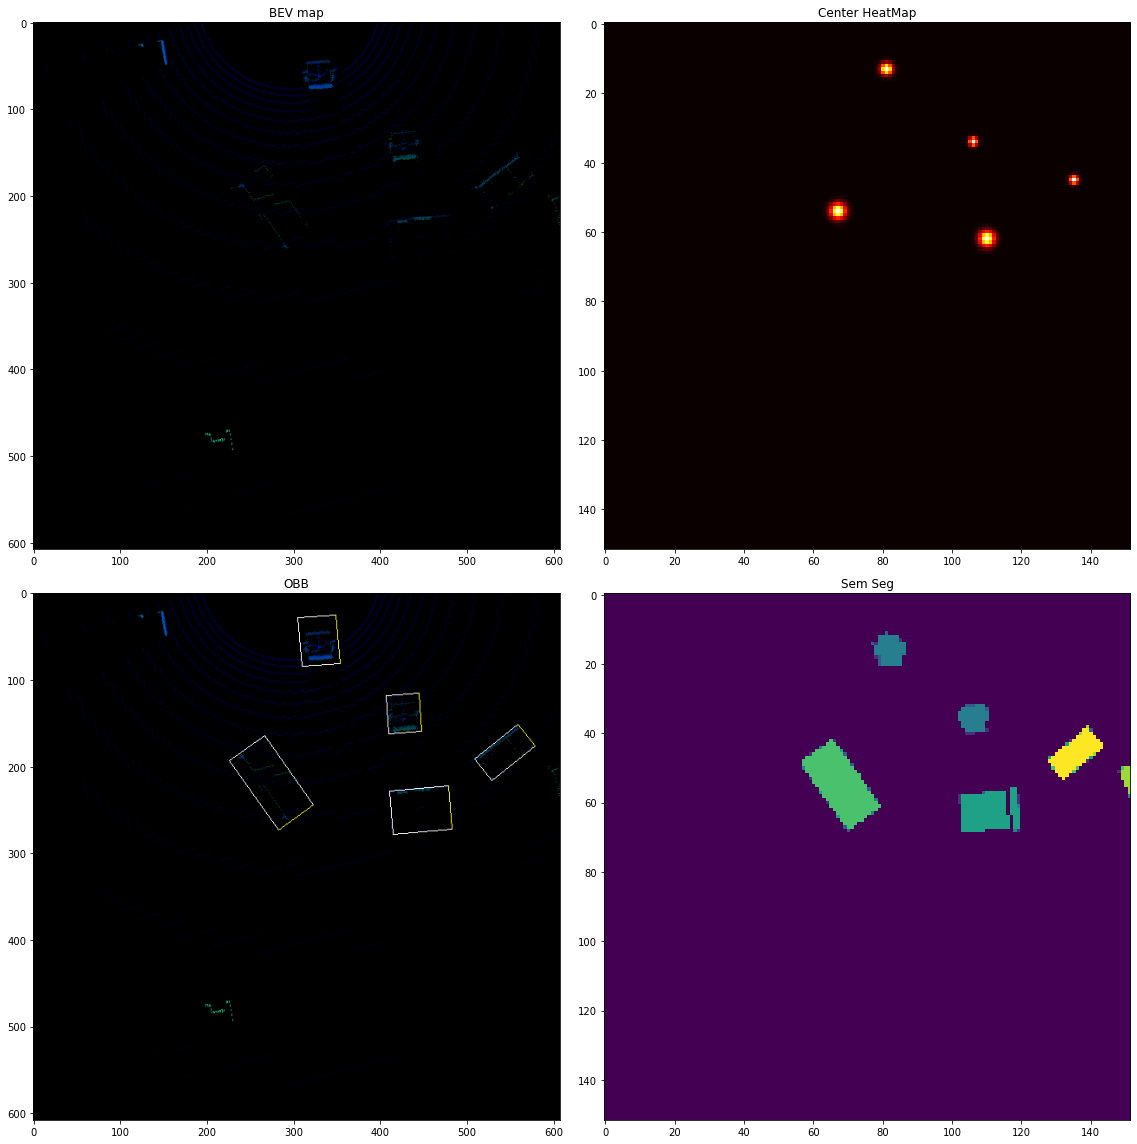

8256


In [20]:
# bev image coordinates format
def get_corners(x, y, w, l, yaw):
    trackletBox = np.array([  # in bev coordinates around zero point and without orientation yet
            [w / 2, w / 2, -w / 2, -w / 2], \
            [-l / 2, l / 2, l / 2, -l / 2], \
            [0, 0, 0, 0]])
    rotMat = np.array([
            [np.cos(yaw), -np.sin(yaw), 0.0],
            [np.sin(yaw), np.cos(yaw), 0.0],
            [0.0, 0.0, 1.0]])
    res = 10/608
    translation = [x/res, y/res+304, 0]
    
    cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (4, 1)).T
    box3d = cornerPosInVelo.transpose()

    return box3d

def drawRotatedBox(img, labels, color, hflip=False):
    for object in labels:
        # Convert the points to a NumPy array
        if hflip == False:
            points = np.delete(get_corners(float(object[1]),float(object[2]),float(object[5]),float(object[6]),float(object[7])).astype(np.int32), 2, axis=1)[:, ::-1]
        else:
            points = np.delete(get_corners(float(object[1]),-float(object[2]),float(object[5]),float(object[6]),-float(object[7])).astype(np.int32), 2, axis=1)[:, ::-1]

        #print(points)
        cv2.polylines(img, [points], True, color, 1)
        #corners_int = bev_corners.reshape(-1, 2)
        cv2.line(img, (int(points[0, 0]), int(points[0, 1])), (int(points[1, 0]), int(points[1, 1])), (255, 255, 0), 1)


configs = parse_configs()

train_lidar_aug = Compose([
        Random_Translation_Y(translation_limit=0.5, p=1.0),
        Random_Rotation(limit_angle=np.pi / 6, p=1.0),
        #Random_Scaling(scaling_range=(0.95, 1.05), p=1.0),
    ], p=1.0)#p=0.66)

train_dataset = SynthDataset(configs, mode='train', lidar_aug=train_lidar_aug, hflip_prob=configs.hflip_prob,
                                 num_samples=configs.num_samples)
print(train_dataset.__len__())
metadatas, bev_map, targets, labels, sem_label, img_rgb = train_dataset.load_img_with_labels(testando)
print(metadatas['hflipped'])
#print(targets['indices_center'][0])
# Convert the tensor to a NumPy array
# Convert the tensor to a NumPy array
numpy_array = (np.transpose(bev_map.numpy(),(1,2,0))* 255).astype(np.uint8) #to display
#numpy_array = bev_map.permute(1, 2, 0).numpy()
cv2.imwrite('./sample.png', numpy_array)


# Convert NumPy array to cv::Mat without using cvtColor
cv_mat = cv2.imread('./sample.png')

merged_hm = np.zeros_like(targets['hm_cen'][0])
for i in range(14):
    merged_hm = np.maximum(merged_hm, targets['hm_cen'][i])

###Oriented BBOX drawing
drawRotatedBox(cv_mat, labels, color=([255, 255, 255]),hflip=metadatas['hflipped'])

#labels, has_label = train_dataset.get_label(0)
print(labels[:,0])

# Create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# Display the first image in the first subplot
axs[0,0].imshow(numpy_array)  # Assuming grayscale, adjust colormap as needed
axs[0,0].set_title('BEV map')

# Display the second image in the second subplot
axs[0,1].imshow(merged_hm, cmap='hot')  # Assuming grayscale, adjust colormap as needed
axs[0,1].set_title('Center HeatMap')

# Display the second image in the second subplot
axs[1,0].imshow(cv_mat)  
axs[1,0].set_title('OBB')

# Display the second image in the second subplot
axs[1,1].imshow(targets['sem_seg'])  
axs[1,1].set_title('Sem Seg')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
plt.close()

# print(targets['cen_offset'])
# print(targets['direction'])
# print(targets['z_coor'])
# print(targets['dim'])
# print(targets['obj_mask'])
# print(targets['sem_seg'])

print(testando)
testando += 1

# Utility Functions

## Logger

In [11]:
import os
import logging


class Logger():
    """
        Create logger to save logs during training
        Args:
            logs_dir:
            saved_fn:
        Returns:
        """

    def __init__(self, logs_dir, saved_fn):
        logger_fn = 'logger_{}.txt'.format(saved_fn)
        logger_path = os.path.join(logs_dir, logger_fn)

        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(logging.INFO)

        # formatter = logging.Formatter('%(asctime)s:File %(module)s.py:Func %(funcName)s:Line %(lineno)d:%(levelname)s: %(message)s')
        formatter = logging.Formatter(
            '%(asctime)s: %(module)s.py - %(funcName)s(), at Line %(lineno)d:%(levelname)s:\n%(message)s')

        file_handler = logging.FileHandler(logger_path)
        file_handler.setLevel(logging.INFO)
        file_handler.setFormatter(formatter)

        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(formatter)

        self.logger.addHandler(file_handler)
        self.logger.addHandler(stream_handler)

    def info(self, message):
        self.logger.info(message)

## Pytorch Utilities

In [12]:
import torch
import torch.distributed as dist

__all__ = ['convert2cpu', 'convert2cpu_long', 'to_cpu', 'reduce_tensor', 'to_python_float', '_sigmoid']


def convert2cpu(gpu_matrix):
    return torch.FloatTensor(gpu_matrix.size()).copy_(gpu_matrix)


def convert2cpu_long(gpu_matrix):
    return torch.LongTensor(gpu_matrix.size()).copy_(gpu_matrix)


def to_cpu(tensor):
    return tensor.detach().cpu()


def reduce_tensor(tensor, world_size):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= world_size
    return rt


def to_python_float(t):
    if hasattr(t, 'item'):
        return t.item()
    else:
        return t[0]


def _sigmoid(x):
    return torch.clamp(x.sigmoid_(), min=1e-4, max=1 - 1e-4)

## Miscellaneous

In [13]:
import os
import torch
import time

def make_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    # or os.makedirs(folder_name, exist_ok=True)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def get_message(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        return '\t'.join(entries)

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def time_synchronized():
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return time.time()

## Learning Rate Scheduler

In [14]:
import torch
from torch.optim import SGD, lr_scheduler
import numpy as np


class _LRMomentumScheduler(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, last_epoch=-1):
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_momentum', group['momentum'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_momentum' not in group:
                    raise KeyError("param 'initial_momentum' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_momentums = list(map(lambda group: group['initial_momentum'], optimizer.param_groups))
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        raise NotImplementedError

    def get_momentum(self):
        raise NotImplementedError

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr, momentum in zip(self.optimizer.param_groups, self.get_lr(), self.get_momentum()):
            param_group['lr'] = lr
            param_group['momentum'] = momentum


class ParameterUpdate(object):
    """A callable class used to define an arbitrary schedule defined by a list.
    This object is designed to be passed to the LambdaLR or LambdaScheduler scheduler to apply
    the given schedule.
    Arguments:
        params {list or numpy.array} -- List or numpy array defining parameter schedule.
        base_param {float} -- Parameter value used to initialize the optimizer.
    """

    def __init__(self, params, base_param):
        self.params = np.hstack([params, 0])
        self.base_param = base_param

    def __call__(self, epoch):
        return self.params[epoch] / self.base_param


def apply_lambda(last_epoch, bases, lambdas):
    return [base * lmbda(last_epoch) for lmbda, base in zip(lambdas, bases)]


class LambdaScheduler(_LRMomentumScheduler):
    """Sets the learning rate and momentum of each parameter group to the initial lr and momentum
    times a given function. When last_epoch=-1, sets initial lr and momentum to the optimizer
    values.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        lr_lambda (function or list): A function which computes a multiplicative
            factor given an integer parameter epoch, or a list of such
            functions, one for each group in optimizer.param_groups.
            Default: lambda x:x.
        momentum_lambda (function or list): As for lr_lambda but applied to momentum.
            Default: lambda x:x.
        last_epoch (int): The index of last epoch. Default: -1.
    Example:
        >>> # Assuming optimizer has two groups.
        >>> lr_lambda = [
        ...     lambda epoch: epoch // 30,
        ...     lambda epoch: 0.95 ** epoch
        ... ]
        >>> mom_lambda = [
        ...     lambda epoch: max(0, (50 - epoch) // 50),
        ...     lambda epoch: 0.99 ** epoch
        ... ]
        >>> scheduler = LambdaScheduler(optimizer, lr_lambda, mom_lambda)
        >>> for epoch in range(100):
        >>>     train(...)
        >>>     validate(...)
        >>>     scheduler.step()
    """

    def __init__(self, optimizer, lr_lambda=lambda x: x, momentum_lambda=lambda x: x, last_epoch=-1):
        self.optimizer = optimizer

        if not isinstance(lr_lambda, (list, tuple)):
            self.lr_lambdas = [lr_lambda] * len(optimizer.param_groups)
        else:
            if len(lr_lambda) != len(optimizer.param_groups):
                raise ValueError("Expected {} lr_lambdas, but got {}".format(
                    len(optimizer.param_groups), len(lr_lambda)))
            self.lr_lambdas = list(lr_lambda)

        if not isinstance(momentum_lambda, (list, tuple)):
            self.momentum_lambdas = [momentum_lambda] * len(optimizer.param_groups)
        else:
            if len(momentum_lambda) != len(optimizer.param_groups):
                raise ValueError("Expected {} momentum_lambdas, but got {}".format(
                    len(optimizer.param_groups), len(momentum_lambda)))
            self.momentum_lambdas = list(momentum_lambda)

        self.last_epoch = last_epoch
        super().__init__(optimizer, last_epoch)

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        The learning rate and momentum lambda functions will only be saved if they are
        callable objects and not if they are functions or lambdas.
        """
        state_dict = {key: value for key, value in self.__dict__.items()
                      if key not in ('optimizer', 'lr_lambdas', 'momentum_lambdas')}
        state_dict['lr_lambdas'] = [None] * len(self.lr_lambdas)
        state_dict['momentum_lambdas'] = [None] * len(self.momentum_lambdas)

        for idx, (lr_fn, mom_fn) in enumerate(zip(self.lr_lambdas, self.momentum_lambdas)):
            if not isinstance(lr_fn, types.FunctionType):
                state_dict['lr_lambdas'][idx] = lr_fn.__dict__.copy()
            if not isinstance(mom_fn, types.FunctionType):
                state_dict['momentum_lambdas'][idx] = mom_fn.__dict__.copy()

        return state_dict

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.
        Arguments:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        lr_lambdas = state_dict.pop('lr_lambdas')
        momentum_lambdas = state_dict.pop('momentum_lambdas')
        self.__dict__.update(state_dict)

        for idx, fn in enumerate(lr_lambdas):
            if fn is not None:
                self.lr_lambdas[idx].__dict__.update(fn)

        for idx, fn in enumerate(momentum_lambdas):
            if fn is not None:
                self.momentum_lambdas[idx].__dict__.update(fn)

    def get_lr(self):
        return apply_lambda(self.last_epoch, self.base_lrs, self.lr_lambdas)

    def get_momentum(self):
        return apply_lambda(self.last_epoch, self.base_momentums, self.momentum_lambdas)


class ParameterUpdate(object):
    """A callable class used to define an arbitrary schedule defined by a list.
    This object is designed to be passed to the LambdaLR or LambdaScheduler scheduler to apply
    the given schedule. If a base_param is zero, no updates are applied.
    Arguments:
        params {list or numpy.array} -- List or numpy array defining parameter schedule.
        base_param {float} -- Parameter value used to initialize the optimizer.
    """

    def __init__(self, params, base_param):
        self.params = np.hstack([params, 0])
        self.base_param = base_param

        if base_param < 1e-12:
            self.base_param = 1
            self.params = self.params * 0.0 + 1.0

    def __call__(self, epoch):
        return self.params[epoch] / self.base_param


class ListScheduler(LambdaScheduler):
    """Sets the learning rate and momentum of each parameter group to values defined by lists.
    When last_epoch=-1, sets initial lr and momentum to the optimizer values. One of both of lr
    and momentum schedules may be specified.
    Note that the parameters used to initialize the optimizer are overriden by those defined by
    this scheduler.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        lrs (list or numpy.ndarray): A list of learning rates, or a list of lists, one for each
            parameter group. One- or two-dimensional numpy arrays may also be passed.
        momentum (list or numpy.ndarray): A list of momentums, or a list of lists, one for each
            parameter group. One- or two-dimensional numpy arrays may also be passed.
        last_epoch (int): The index of last epoch. Default: -1.
    Example:
        >>> # Assuming optimizer has two groups.
        >>> lrs = [
        ...     np.linspace(0.01, 0.1, 100),
        ...     np.logspace(-2, 0, 100)
        ... ]
        >>> momentums = [
        ...     np.linspace(0.85, 0.95, 100),
        ...     np.linspace(0.8, 0.99, 100)
        ... ]
        >>> scheduler = ListScheduler(optimizer, lrs, momentums)
        >>> for epoch in range(100):
        >>>     train(...)
        >>>     validate(...)
        >>>     scheduler.step()
    """

    def __init__(self, optimizer, lrs=None, momentums=None, last_epoch=-1):
        groups = optimizer.param_groups
        if lrs is None:
            lr_lambda = lambda x: x
        else:
            lrs = np.array(lrs) if isinstance(lrs, (list, tuple)) else lrs
            if len(lrs.shape) == 1:
                lr_lambda = [ParameterUpdate(lrs, g['lr']) for g in groups]
            else:
                lr_lambda = [ParameterUpdate(l, g['lr']) for l, g in zip(lrs, groups)]

        if momentums is None:
            momentum_lambda = lambda x: x
        else:
            momentums = np.array(momentums) if isinstance(momentums, (list, tuple)) else momentums
            if len(momentums.shape) == 1:
                momentum_lambda = [ParameterUpdate(momentums, g['momentum']) for g in groups]
            else:
                momentum_lambda = [ParameterUpdate(l, g['momentum']) for l, g in zip(momentums, groups)]
        super().__init__(optimizer, lr_lambda, momentum_lambda)


class RangeFinder(ListScheduler):
    """Scheduler class that implements the LR range search specified in:
        A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch
        size, momentum, and weight decay. Leslie N. Smith, 2018, arXiv:1803.09820.
    Logarithmically spaced learning rates from 1e-7 to 1 are searched. The number of increments in
    that range is determined by 'epochs'.
    Note that the parameters used to initialize the optimizer are overriden by those defined by
    this scheduler.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        epochs (int): Number of epochs over which to run test.
    Example:
        >>> scheduler = RangeFinder(optimizer, 100)
        >>> for epoch in range(100):
        >>>     train(...)
        >>>     validate(...)
        >>>     scheduler.step()
    """

    def __init__(self, optimizer, epochs):
        lrs = np.logspace(-7, 0, epochs)
        super().__init__(optimizer, lrs)


class OneCyclePolicy(ListScheduler):
    """Scheduler class that implements the 1cycle policy search specified in:
        A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch
        size, momentum, and weight decay. Leslie N. Smith, 2018, arXiv:1803.09820.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        lr (float or list). Maximum learning rate in range. If a list of values is passed, they
            should correspond to parameter groups.
        epochs (int): The number of epochs to use during search.
        momentum_rng (list). Optional upper and lower momentum values (may be both equal). Set to
            None to run without momentum. Default: [0.85, 0.95]. If a list of lists is passed, they
            should correspond to parameter groups.
        phase_ratio (float): Fraction of epochs used for the increasing and decreasing phase of
            the schedule. For example, if phase_ratio=0.45 and epochs=100, the learning rate will
            increase from lr/10 to lr over 45 epochs, then decrease back to lr/10 over 45 epochs,
            then decrease to lr/100 over the remaining 10 epochs. Default: 0.45.
    """

    def __init__(self, optimizer, lr, epochs, momentum_rng=[0.85, 0.95], phase_ratio=0.45):
        phase_epochs = int(phase_ratio * epochs)
        if isinstance(lr, (list, tuple)):
            lrs = [
                np.hstack([
                    np.linspace(l * 1e-1, l, phase_epochs),
                    np.linspace(l, l * 1e-1, phase_epochs),
                    np.linspace(l * 1e-1, l * 1e-2, epochs - 2 * phase_epochs),
                ]) for l in lr
            ]
        else:
            lrs = np.hstack([
                np.linspace(lr * 1e-1, lr, phase_epochs),
                np.linspace(lr, lr * 1e-1, phase_epochs),
                np.linspace(lr * 1e-1, lr * 1e-2, epochs - 2 * phase_epochs),
            ])

        if momentum_rng is not None:
            momentum_rng = np.array(momentum_rng)
            if len(momentum_rng.shape) == 2:
                for i, g in enumerate(optimizer.param_groups):
                    g['momentum'] = momentum_rng[i][1]
                momentums = [
                    np.hstack([
                        np.linspace(m[1], m[0], phase_epochs),
                        np.linspace(m[0], m[1], phase_epochs),
                        np.linspace(m[1], m[1], epochs - 2 * phase_epochs),
                    ]) for m in momentum_rng
                ]
            else:
                for i, g in enumerate(optimizer.param_groups):
                    g['momentum'] = momentum_rng[1]
                momentums = np.hstack([
                    np.linspace(momentum_rng[1], momentum_rng[0], phase_epochs),
                    np.linspace(momentum_rng[0], momentum_rng[1], phase_epochs),
                    np.linspace(momentum_rng[1], momentum_rng[1], epochs - 2 * phase_epochs),
                ])
        else:
            momentums = None

        super().__init__(optimizer, lrs, momentums)

## Train Utility Functions

In [15]:
import copy
import os
import math
import sys

import torch
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt


def create_optimizer(configs, model):
    """Create optimizer for training process
    """
    if hasattr(model, 'module'):
        train_params = [param for param in model.module.parameters() if param.requires_grad]
    else:
        train_params = [param for param in model.parameters() if param.requires_grad]

    if configs.optimizer_type == 'sgd':
        optimizer = torch.optim.SGD(train_params, lr=configs.lr, momentum=configs.momentum, nesterov=True)
    elif configs.optimizer_type == 'adam':
        optimizer = torch.optim.Adam(train_params, lr=configs.lr, weight_decay=configs.weight_decay)
    else:
        assert False, "Unknown optimizer type"

    return optimizer


def create_lr_scheduler(optimizer, configs):
    """Create learning rate scheduler for training process"""

    if configs.lr_type == 'multi_step':
        def multi_step_scheduler(i):
            if i < configs.steps[0]:
                factor = 1.
            elif i < configs.steps[1]:
                factor = 0.1
            else:
                factor = 0.01

            return factor

        lr_scheduler = LambdaLR(optimizer, multi_step_scheduler)

    elif configs.lr_type == 'cosin':
        # Scheduler https://arxiv.org/pdf/1812.01187.pdf
        lf = lambda x: (((1 + math.cos(x * math.pi / configs.num_epochs)) / 2) ** 1.0) * 0.9 + 0.1  # cosine
        lr_scheduler = LambdaLR(optimizer, lr_lambda=lf)
    elif configs.lr_type == 'one_cycle':
        lr_scheduler = OneCyclePolicy(optimizer, configs.lr, configs.num_epochs, momentum_rng=[0.85, 0.95],
                                      phase_ratio=0.45)
    else:
        raise ValueError

    plot_lr_scheduler(optimizer, lr_scheduler, configs.num_epochs, save_dir=configs.logs_dir, lr_type=configs.lr_type)

    return lr_scheduler


def get_saved_state(model, optimizer, lr_scheduler, epoch, configs):
    """Get the information to save with checkpoints"""
    if hasattr(model, 'module'):
        model_state_dict = model.module.state_dict()
    else:
        model_state_dict = model.state_dict()
    utils_state_dict = {
        'epoch': epoch,
        'configs': configs,
        'optimizer': copy.deepcopy(optimizer.state_dict()),
        'lr_scheduler': copy.deepcopy(lr_scheduler.state_dict())
    }

    return model_state_dict, utils_state_dict


def save_checkpoint(checkpoints_dir, saved_fn, model_state_dict, utils_state_dict, epoch):
    """Save checkpoint every epoch only is best model or after every checkpoint_freq epoch"""
    model_save_path = os.path.join(checkpoints_dir, 'Model_{}_epoch_{}.pth'.format(saved_fn, epoch))
    utils_save_path = os.path.join(checkpoints_dir, 'Utils_{}_epoch_{}.pth'.format(saved_fn, epoch))

    torch.save(model_state_dict, model_save_path)
    torch.save(utils_state_dict, utils_save_path)

    print('save a checkpoint at {}'.format(model_save_path))


def plot_lr_scheduler(optimizer, scheduler, num_epochs=300, save_dir='', lr_type=''):
    # Plot LR simulating training for full num_epochs
    optimizer, scheduler = copy.copy(optimizer), copy.copy(scheduler)  # do not modify originals
    y = []
    for _ in range(num_epochs):
        scheduler.step()
        y.append(optimizer.param_groups[0]['lr'])
    plt.plot(y, '.-', label='LR')
    plt.xlabel('epoch')
    plt.ylabel('LR')
    plt.grid()
    plt.xlim(0, num_epochs)
    plt.ylim(0)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'LR_{}.png'.format(lr_type)), dpi=200)

## Evaluation Utility Functions

In [16]:
from __future__ import division
import os
import sys

import torch
import numpy as np
import torch.nn.functional as F
import cv2

def _nms(heat, kernel=3):
    pad = (kernel - 1) // 2
    hmax = F.max_pool2d(heat, (kernel, kernel), stride=1, padding=pad)
    keep = (hmax == heat).float()

    return heat * keep


def _gather_feat(feat, ind, mask=None):
    dim = feat.size(2)
    ind = ind.unsqueeze(2).expand(ind.size(0), ind.size(1), dim)
    feat = feat.gather(1, ind)
    if mask is not None:
        mask = mask.unsqueeze(2).expand_as(feat)
        feat = feat[mask]
        feat = feat.view(-1, dim)
    return feat


def _transpose_and_gather_feat(feat, ind):
    feat = feat.permute(0, 2, 3, 1).contiguous()
    feat = feat.view(feat.size(0), -1, feat.size(3))
    feat = _gather_feat(feat, ind)
    return feat


def _topk(scores, K=40):
    batch, cat, height, width = scores.size()

    topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)

    topk_inds = topk_inds % (height * width)
    topk_ys = (torch.floor_divide(topk_inds, width)).float()
    topk_xs = (topk_inds % width).int().float()

    topk_score, topk_ind = torch.topk(topk_scores.view(batch, -1), K)
    topk_clses = (torch.floor_divide(topk_ind, K)).int()
    topk_inds = _gather_feat(topk_inds.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_ys = _gather_feat(topk_ys.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_xs = _gather_feat(topk_xs.view(batch, -1, 1), topk_ind).view(batch, K)

    return topk_score, topk_inds, topk_clses, topk_ys, topk_xs


def _topk_channel(scores, K=40):
    batch, cat, height, width = scores.size()

    topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)

    topk_inds = topk_inds % (height * width)
    topk_ys = (topk_inds / width).int().float()
    topk_xs = (topk_inds % width).int().float()

    return topk_scores, topk_inds, topk_ys, topk_xs


def decode(hm_cen, cen_offset, direction, z_coor, dim, K=40):
    batch_size, num_classes, height, width = hm_cen.size()

    hm_cen = _nms(hm_cen)
    scores, inds, clses, ys, xs = _topk(hm_cen, K=K)
    if cen_offset is not None:
        cen_offset = _transpose_and_gather_feat(cen_offset, inds)
        cen_offset = cen_offset.view(batch_size, K, 2)
        xs = xs.view(batch_size, K, 1) + cen_offset[:, :, 0:1]
        ys = ys.view(batch_size, K, 1) + cen_offset[:, :, 1:2]
    else:
        xs = xs.view(batch_size, K, 1) + 0.5
        ys = ys.view(batch_size, K, 1) + 0.5

    direction = _transpose_and_gather_feat(direction, inds)
    direction = direction.view(batch_size, K, 2)
    z_coor = _transpose_and_gather_feat(z_coor, inds)
    z_coor = z_coor.view(batch_size, K, 1)
    dim = _transpose_and_gather_feat(dim, inds)
    dim = dim.view(batch_size, K, 3)
    clses = clses.view(batch_size, K, 1).float()
    scores = scores.view(batch_size, K, 1)

    # (scores x 1, ys x 1, xs x 1, z_coor x 1, dim x 3, direction x 2, clses x 1)
    # (scores-0:1, ys-1:2, xs-2:3, z_coor-3:4, dim-4:7, direction-7:9, clses-9:10)
    # detections: [batch_size, K, 10]
    detections = torch.cat([scores, xs, ys, z_coor, dim, direction, clses], dim=2)

    return detections


def get_yaw(direction):
    return np.arctan2(direction[:, 0:1], direction[:, 1:2])


def post_processing(detections, num_classes=14, down_ratio=4, peak_thresh=0.2):
    """
    :param detections: [batch_size, K, 10]
    # (scores x 1, xs x 1, ys x 1, z_coor x 1, dim x 3, direction x 2, clses x 1)
    # (scores-0:1, xs-1:2, ys-2:3, z_coor-3:4, dim-4:7, direction-7:9, clses-9:10)
    :return:
    """
    # TODO: Need to consider rescale to the original scale: x, y

    ret = []
    for i in range(detections.shape[0]):
        top_preds = {}
        classes = detections[i, :, -1]
        for j in range(num_classes):
            inds = (classes == j)

            # x, y, z, h, w, l, yaw
            top_preds[j] = np.concatenate([
                detections[i, inds, 0:1],
                detections[i, inds, 1:2] * down_ratio,
                detections[i, inds, 2:3] * down_ratio,
                detections[i, inds, 3:4],
                detections[i, inds, 4:5],
                detections[i, inds, 5:6] / bound_size_y * BEV_WIDTH,
                detections[i, inds, 6:7] / bound_size_x * BEV_HEIGHT,
                get_yaw(detections[i, inds, 7:9]).astype(np.float32)], axis=1)
            # Filter by peak_thresh
            if len(top_preds[j]) > 0:
                keep_inds = (top_preds[j][:, 0] > peak_thresh)
                top_preds[j] = top_preds[j][keep_inds]
        ret.append(top_preds)

    return ret


def draw_predictions(img, detections, num_classes=3):
    for j in range(num_classes):
        if len(detections[j]) > 0:
            for det in detections[j]:
                # (scores-0:1, x-1:2, y-2:3, z-3:4, dim-4:7, yaw-7:8)
                _score, _x, _y, _z, _h, _w, _l, _yaw = det
                drawRotatedBox(img, _x, _y, _l, _w, _yaw, colors[int(j)])

    return img


def convert_det_to_real_values(detections, num_classes=14):
    kitti_dets = []
    for cls_id in range(num_classes):
        if len(detections[cls_id]) > 0:
            for det in detections[cls_id]:
                # (scores-0:1, x-1:2, y-2:3, z-3:4, dim-4:7, yaw-7:8)
                _score, _x, _y, _z, _h, _w, _l, _yaw = det
                _yaw = -_yaw
                x = _y / BEV_HEIGHT * bound_size_x + boundary['minX']
                y = _x / BEV_WIDTH * bound_size_y + boundary['minY']
                z = _z + boundary['minZ']
                w = _w / BEV_WIDTH * bound_size_y
                l = _l / BEV_HEIGHT * bound_size_x

                kitti_dets.append([cls_id, x, y, z, _h, w, l, _yaw])

    return np.array(kitti_dets)

## Visualization Utility Functions

In [17]:
from __future__ import print_function
import os
import sys

import numpy as np
import cv2


def roty(angle):
    # Rotation about the y-axis.
    c = np.cos(angle)
    s = np.sin(angle)
    return np.array([[c, 0, s],
                     [0, 1, 0],
                     [-s, 0, c]])


def compute_box_3d(dim, location, ry):
    # dim: 3
    # location: 3
    # ry: 1
    # return: 8 x 3
    R = roty(ry)
    h, l, w = dim
    x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
    z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]

    corners = np.array([x_corners, y_corners, z_corners], dtype=np.float32)
    corners_3d = np.dot(R, corners)
    corners_3d = corners_3d + np.array(location, dtype=np.float32).reshape(3, 1)
    return corners_3d.transpose(1, 0)


def project_to_image(pts_3d, P):
    # pts_3d: n x 3
    # P: 3 x 4
    # return: n x 2
    pts_3d_homo = np.concatenate([pts_3d, np.ones((pts_3d.shape[0], 1), dtype=np.float32)], axis=1)
    pts_2d = np.dot(P, pts_3d_homo.transpose(1, 0)).transpose(1, 0)
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:]

    return pts_2d.astype(np.int)


def draw_box_3d_v2(image, qs, color=(255, 0, 255), thickness=2):
    ''' Draw 3d bounding box in image
        qs: (8,3) array of vertices for the 3d box in following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
    '''
    qs = qs.astype(np.int32)
    for k in range(0, 4):
        # Ref: http://docs.enthought.com/mayavi/mayavi/auto/mlab_helper_functions.html
        i, j = k, (k + 1) % 4
        # use LINE_AA for opencv3
        cv2.line(image, (qs[i, 0], qs[i, 1]), (qs[j, 0], qs[j, 1]), color, thickness)

        i, j = k + 4, (k + 1) % 4 + 4
        cv2.line(image, (qs[i, 0], qs[i, 1]), (qs[j, 0], qs[j, 1]), color, thickness)

        i, j = k, k + 4
        cv2.line(image, (qs[i, 0], qs[i, 1]), (qs[j, 0], qs[j, 1]), color, thickness)

    return image


def draw_box_3d(image, corners, color=(0, 0, 255)):
    ''' Draw 3d bounding box in image
        corners: (8,3) array of vertices for the 3d box in following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
    '''

    face_idx = [[0, 1, 5, 4],
                [1, 2, 6, 5],
                [2, 3, 7, 6],
                [3, 0, 4, 7]]
    for ind_f in range(3, -1, -1):
        f = face_idx[ind_f]
        for j in range(4):
            cv2.line(image, (corners[f[j], 0], corners[f[j], 1]),
                     (corners[f[(j + 1) % 4], 0], corners[f[(j + 1) % 4], 1]), color, 2, lineType=cv2.LINE_AA)
        if ind_f == 0:
            cv2.line(image, (corners[f[0], 0], corners[f[0], 1]),
                     (corners[f[2], 0], corners[f[2], 1]), color, 1, lineType=cv2.LINE_AA)
            cv2.line(image, (corners[f[1], 0], corners[f[1], 1]),
                     (corners[f[3], 0], corners[f[3], 1]), color, 1, lineType=cv2.LINE_AA)

    return image


def show_rgb_image_with_boxes(img, labels):
    for box_idx, label in enumerate(labels):
        cls_id, location, dim, ry = label[0], label[1:4], label[4:7], label[7]
        if location[2] < 1.3:  # The object is too close to the camera, ignore it during visualization
            continue
        if cls_id < 0:
            continue
        corners_3d = compute_box_3d(dim, location, ry)
        # print(corners_3d)
        corners_2d = project_to_image(corners_3d, P2)
        # print(corners_2d)
        img = draw_box_3d(img, corners_2d, color=colors[int(cls_id)])

    return img


def merge_rgb_to_bev(img_rgb, img_bev, output_width):
    img_rgb_h, img_rgb_w = img_rgb.shape[:2]
    ratio_rgb = output_width / img_rgb_w
    output_rgb_h = int(ratio_rgb * img_rgb_h)
    ret_img_rgb = cv2.resize(img_rgb, (output_width, output_rgb_h))

    img_bev_h, img_bev_w = img_bev.shape[:2]
    ratio_bev = output_width / img_bev_w
    output_bev_h = int(ratio_bev * img_bev_h)

    ret_img_bev = cv2.resize(img_bev, (output_width, output_bev_h))

    out_img = np.zeros((output_rgb_h + output_bev_h, output_width, 3), dtype=np.uint8)
    # Upper: RGB --> BEV
    out_img[:output_rgb_h, ...] = ret_img_rgb
    out_img[output_rgb_h:, ...] = ret_img_bev

    return out_img

## Demo Utility Functions

In [18]:
import sys
import os
from builtins import int
from glob import glob

import numpy as np
from torch.utils.data import Dataset
import cv2
import torch


class Demo_SynthDataset(Dataset):
    def __init__(self, configs):
        self.dataset_dir = os.path.join(configs.dataset_dir, configs.foldername, configs.foldername[:10],
                                        configs.foldername)
        self.input_size = configs.input_size
        self.hm_size = configs.hm_size

        self.num_classes = configs.num_classes
        self.max_objects = configs.max_objects

        self.image_dir = os.path.join(self.dataset_dir, "image_02", "data")
        self.lidar_dir = os.path.join(self.dataset_dir, "velodyne_points", "data")
        self.label_dir = os.path.join(self.dataset_dir, "label_2", "data")
        self.sample_id_list = sorted(glob(os.path.join(self.lidar_dir, '*.bin')))
        self.sample_id_list = [float(os.path.basename(fn)[:-4]) for fn in self.sample_id_list]
        self.num_samples = len(self.sample_id_list)

    def __len__(self):
        return len(self.sample_id_list)

    def __getitem__(self, index):
        pass

    def load_bevmap_front(self, index):
        """Load only image for the testing phase"""
        sample_id = int(self.sample_id_list[index])
        img_path, img_rgb = self.get_image(sample_id)
        lidarData = self.get_lidar(sample_id)
        front_lidar = get_filtered_lidar(lidarData, boundary)
        front_bevmap = makeBEVMap(front_lidar, boundary)
        front_bevmap = torch.from_numpy(front_bevmap)

        metadatas = {
            'img_path': img_path,
        }

        return metadatas, front_bevmap, img_rgb

    def load_bevmap_front_vs_back(self, index):
        """Load only image for the testing phase"""
        sample_id = int(self.sample_id_list[index])
        img_path, img_rgb = self.get_image(sample_id)
        lidarData = self.get_lidar(sample_id)

        front_lidar = get_filtered_lidar(lidarData, boundary)
        front_bevmap = makeBEVMap(front_lidar, boundary)
        front_bevmap = torch.from_numpy(front_bevmap)

        back_lidar = get_filtered_lidar(lidarData, boundary_back)
        back_bevmap = makeBEVMap(back_lidar, boundary_back)
        back_bevmap = torch.from_numpy(back_bevmap)

        metadatas = {
            'img_path': img_path,
        }

        return metadatas, front_bevmap, back_bevmap, img_rgb

    def get_image(self, idx):
        img_path = os.path.join(self.image_dir, '{:010d}.png'.format(idx))
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        return img_path, img

    def get_lidar(self, idx):
        lidar_file = os.path.join(self.lidar_dir, '{:010d}.bin'.format(idx))
        # assert os.path.isfile(lidar_file)
        return np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)

In [19]:
import argparse
import sys
import os
import warnings
import zipfile

warnings.filterwarnings("ignore", category=UserWarning)

from easydict import EasyDict as edict
import numpy as np
import wget
import torch
import cv2


def parse_demo_configs():
    config_dict = {}
    config_dict['saved_fn'] = 'fpn_resnet_50_semseg'
    config_dict['arch'] = 'fpn_resnet_50'
    config_dict['pretrained_path'] = './checkpoints/fpn_resnet_50_semseg/Model_fpn_resnet_50_semseg_epoch_262.pth'
    # config_dict['foldername'] = '2011_09_26_drive_0014_sync'
    config_dict['K'] = 50
    config_dict['gpu_idx'] = 0
    config_dict['peak_thresh'] = 0.3
    config_dict['output_width'] = 608
    config_dict['no_cuda'] = False

    configs = edict(config_dict)
    configs.pin_memory = True
    configs.distributed = False  # For testing on 1 GPU only

    configs.input_size = (608, 608)
    configs.hm_size = (152, 152)
    configs.down_ratio = 4
    configs.max_objects = 50

    configs.imagenet_pretrained = False
    configs.head_conv = 64
    configs.num_classes = 14
    configs.num_center_offset = 2
    configs.num_z = 1
    configs.num_dim = 3
    configs.num_direction = 2  # sin, cos

    configs.heads = {
        'hm_cen': configs.num_classes,
        'cen_offset': configs.num_center_offset,
        'direction': configs.num_direction,
        'z_coor': configs.num_z,
        'dim': configs.num_dim
    }

    ####################################################################
    ##############Dataset, Checkpoints, and results dir configs#########
    ####################################################################
    configs.root_dir = './'
    configs.dataset_dir = os.path.join(configs.root_dir, 'synth_depot_dataset')
    configs.results_dir = os.path.join(configs.root_dir, 'results', configs.saved_fn)
    make_folder(configs.results_dir)

    return configs


# def download_and_unzip(demo_dataset_dir, download_url):
#     filename = download_url.split('/')[-1]
#     filepath = os.path.join(demo_dataset_dir, filename)
#     if os.path.isfile(filepath):
#         print('The dataset have been downloaded')
#         return
#     print('\nDownloading data for demonstration...')
#     wget.download(download_url, filepath)
#     print('\nUnzipping the downloaded data...')
#     with zipfile.ZipFile(filepath, "r") as zip_ref:
#         zip_ref.extractall(os.path.join(demo_dataset_dir, filename[:-4]))


def do_detect(configs, model, bevmap): #, is_front):
    # if not is_front:
    #     bevmap = torch.flip(bevmap, [1, 2])

    input_bev_maps = bevmap.unsqueeze(0).to(configs.device, non_blocking=True).float()
    t1 = time_synchronized()
    outputs = model(input_bev_maps)
    outputs['hm_cen'] = _sigmoid(outputs['hm_cen'])
    outputs['cen_offset'] = _sigmoid(outputs['cen_offset'])
    outputs['sem_seg'] = F.softmax(outputs['sem_seg'], dim=1)
    seg_out = outputs['sem_seg'].squeeze(0).cpu().numpy()
    seg_out = np.argmax(seg_out, axis = 0)
    
    # detections size (batch_size, K, 10)
    detections = decode(outputs['hm_cen'], outputs['cen_offset'], outputs['direction'], outputs['z_coor'],
                        outputs['dim'], K=configs.K)
    detections = detections.cpu().numpy().astype(np.float32)
    detections = post_processing(detections, configs.num_classes, configs.down_ratio, configs.peak_thresh)
    t2 = time_synchronized()
    # Inference speed
    fps = 1 / (t2 - t1)

    return detections[0], bevmap, fps, seg_out


def write_credit(img, org_author=(500, 400), text_author='github.com/danilogsch', org_fps=(50, 1000), fps=None):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.8
    color = (255, 255, 255)
    thickness = 2

    cv2.putText(img, text_author, org_author, font, fontScale, color, thickness, cv2.LINE_AA)
    cv2.putText(img, 'Frame Rate: {:.1f} FPS'.format(fps), org_fps, font, fontScale, color, thickness, cv2.LINE_AA)

def write_confidence(img, org_confidence=(500, 400), confidence=None):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.7
    color = (0, 0, 0)
    thickness = 2
    txt_string = 'Confidences: '+', '.join(confidence)
    #print(type(txt_string))
    cv2.putText(img, txt_string, org_confidence, font, fontScale, color, thickness, cv2.LINE_AA)

# Loss Functions

In [20]:
from __future__ import print_function, division

import os
import sys
import math

import torch.nn as nn
import torch
import torch.nn.functional as F

from torch.autograd import Variable
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse as ifilterfalse




def _gather_feat(feat, ind, mask=None):
    dim = feat.size(2)
    ind = ind.unsqueeze(2).expand(ind.size(0), ind.size(1), dim)
    feat = feat.gather(1, ind)
    if mask is not None:
        mask = mask.unsqueeze(2).expand_as(feat)
        feat = feat[mask]
        feat = feat.view(-1, dim)
    return feat


def _transpose_and_gather_feat(feat, ind):
    feat = feat.permute(0, 2, 3, 1).contiguous()
    feat = feat.view(feat.size(0), -1, feat.size(3))
    feat = _gather_feat(feat, ind)
    return feat


def _neg_loss(pred, gt, alpha=2, beta=4):
    ''' Modified focal loss. Exactly the same as CornerNet.
        Runs faster and costs a little bit more memory
      Arguments:
        pred (batch x c x h x w)
        gt_regr (batch x c x h x w)
    '''
    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()

    neg_weights = torch.pow(1 - gt, beta)

    loss = 0

    pos_loss = torch.log(pred) * torch.pow(1 - pred, alpha) * pos_inds
    neg_loss = torch.log(1 - pred) * torch.pow(pred, alpha) * neg_weights * neg_inds

    num_pos = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0:
        loss = loss - neg_loss
    else:
        loss = loss - (pos_loss + neg_loss) / num_pos
    return loss

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def _lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    if probas.dim() == 3:
        # assumes output of a sigmoid layer
        B, H, W = probas.size()
        probas = probas.view(B, 1, H, W)
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------
def isnan(x):
    return x != x
    
    
def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

class LovaszLoss(nn.Module):
    '''nn.Module warpper for Lovasz Softmax loss'''
    def __init__(self):
        super(LovaszLoss, self).__init__()
        self.lovasz_softmax = _lovasz_softmax
    
    def forward(self, out, target):
        out_prob = F.softmax(out, dim=1)
        return self.lovasz_softmax(out_prob, target, classes='all', per_image=False, ignore=None)

class FocalLoss(nn.Module):
    '''nn.Module warpper for focal loss'''

    def __init__(self):
        super(FocalLoss, self).__init__()
        self.neg_loss = _neg_loss

    def forward(self, out, target):
        return self.neg_loss(out, target)


class L1Loss(nn.Module):
    def __init__(self):
        super(L1Loss, self).__init__()

    def forward(self, output, mask, ind, target):
        pred = _transpose_and_gather_feat(output, ind)
        mask = mask.unsqueeze(2).expand_as(pred).float()
        loss = F.l1_loss(pred * mask, target * mask, size_average=False)
        loss = loss / (mask.sum() + 1e-4)
        return loss


class L1Loss_Balanced(nn.Module):
    """Balanced L1 Loss
    paper: https://arxiv.org/pdf/1904.02701.pdf (CVPR 2019)
    Code refer from: https://github.com/OceanPang/Libra_R-CNN
    """

    def __init__(self, alpha=0.5, gamma=1.5, beta=1.0):
        super(L1Loss_Balanced, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        assert beta > 0
        self.beta = beta

    def forward(self, output, mask, ind, target):
        pred = _transpose_and_gather_feat(output, ind)
        mask = mask.unsqueeze(2).expand_as(pred).float()
        loss = self.balanced_l1_loss(pred * mask, target * mask)
        loss = loss.sum() / (mask.sum() + 1e-4)

        return loss

    def balanced_l1_loss(self, pred, target):
        assert pred.size() == target.size() and target.numel() > 0

        diff = torch.abs(pred - target)
        b = math.exp(self.gamma / self.alpha) - 1
        loss = torch.where(diff < self.beta,
                           self.alpha / b * (b * diff + 1) * torch.log(b * diff / self.beta + 1) - self.alpha * diff,
                           self.gamma * diff + self.gamma / b - self.alpha * self.beta)

        return loss


class Compute_Loss(nn.Module):
    def __init__(self, device):
        super(Compute_Loss, self).__init__()
        self.device = device
        self.focal_loss = FocalLoss()
        self.l1_loss = L1Loss()
        self.l1_loss_balanced = L1Loss_Balanced(alpha=0.5, gamma=1.5, beta=1.0)
        self.lovasz_softmax_loss = LovaszLoss()

        self.weight_hm_cen = 1.
        self.weight_sem_seg = 1.
        self.weight_z_coor, self.weight_cenoff, self.weight_dim, self.weight_direction = 1., 1., 1., 1.

    def forward(self, outputs, tg):
        # tg: targets
        outputs['hm_cen'] = _sigmoid(outputs['hm_cen'])
        outputs['cen_offset'] = _sigmoid(outputs['cen_offset'])
        #outputs['sem_seg'] = _sigmoid(outputs['sem_seg']) #rancar?

        l_hm_cen = self.focal_loss(outputs['hm_cen'], tg['hm_cen'])
        l_cen_offset = self.l1_loss(outputs['cen_offset'], tg['obj_mask'], tg['indices_center'], tg['cen_offset'])
        l_direction = self.l1_loss(outputs['direction'], tg['obj_mask'], tg['indices_center'], tg['direction'])
        # Apply the L1_loss balanced for z coor and dimension regression
        l_z_coor = self.l1_loss_balanced(outputs['z_coor'], tg['obj_mask'], tg['indices_center'], tg['z_coor'])
        l_dim = self.l1_loss_balanced(outputs['dim'], tg['obj_mask'], tg['indices_center'], tg['dim'])
        #   Apply Sem. Seg loss
        l_sem_seg = self.lovasz_softmax_loss(outputs['sem_seg'], tg['sem_seg'])

        total_loss = l_hm_cen * self.weight_hm_cen + l_cen_offset * self.weight_cenoff + \
                     l_dim * self.weight_dim + l_direction * self.weight_direction + \
                     l_z_coor * self.weight_z_coor + l_sem_seg * self.weight_sem_seg

        loss_stats = {
            'total_loss': to_cpu(total_loss).item(),
            'hm_cen_loss': to_cpu(l_hm_cen).item(),
            'cen_offset_loss': to_cpu(l_cen_offset).item(),
            'dim_loss': to_cpu(l_dim).item(),
            'direction_loss': to_cpu(l_direction).item(),
            'z_coor_loss': to_cpu(l_z_coor).item(),
            'sem_seg_loss': to_cpu(l_sem_seg).item(),
        }

        return total_loss, loss_stats

<>:113: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:113: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_38566/530556368.py:113: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (classes is 'present' and fg.sum() == 0):


# Model

## FPN ResNet

In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

BN_MOMENTUM = 0.1

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class PoseResNet(nn.Module):

    def __init__(self, block, layers, heads, head_conv, **kwargs):
        self.inplanes = 64
        self.deconv_with_bias = False
        self.heads = heads

        super(PoseResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.conv_up_level1 = nn.Conv2d(768* block.expansion, 256* block.expansion, kernel_size=1, stride=1, padding=0)
        self.conv_up_level2 = nn.Conv2d(384* block.expansion, 128* block.expansion, kernel_size=1, stride=1, padding=0)
        self.conv_up_level3 = nn.Conv2d(192* block.expansion, 64* block.expansion, kernel_size=1, stride=1, padding=0)

        fpn_channels = [256* block.expansion, 128* block.expansion, 64* block.expansion]
        for fpn_idx, fpn_c in enumerate(fpn_channels):
            for head in sorted(self.heads):
                num_output = self.heads[head]
                if head_conv > 0:
                    fc = nn.Sequential(
                        nn.Conv2d(fpn_c, head_conv, kernel_size=3, padding=1, bias=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(head_conv, num_output, kernel_size=1, stride=1, padding=0))
                else:
                    fc = nn.Conv2d(in_channels=fpn_c, out_channels=num_output, kernel_size=1, stride=1, padding=0)

                self.__setattr__('fpn{}_{}'.format(fpn_idx, head), fc)

        self.fseg_top = nn.Sequential(
                        nn.Conv2d(2048, 512, 3, padding=1, bias=False),
                        nn.BatchNorm2d(512),
                        nn.ReLU(),
                        nn.Dropout(0.1),
                        nn.Conv2d(512, 15, 1),
                        # First transposed convolution layer (upscale by 2)
                        # nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
                        # nn.BatchNorm2d(128, momentum=BN_MOMENTUM),
                        # nn.ReLU(inplace=True),
        )
        self.fseg_mid = nn.Sequential(
                        nn.Conv2d(1024, 256, 3, padding=1, bias=False),
                        nn.BatchNorm2d(256),
                        nn.ReLU(),
                        nn.Dropout(0.1),
                        nn.Conv2d(256, 15, 1),
        )
        self.fseg_bot = nn.Sequential(
                        nn.Conv2d(512, 128, 3, padding=1, bias=False),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.Dropout(0.1),
                        nn.Conv2d(128, 15, 1),
        )
        #self.conv_up_seg = nn.Conv2d(192, 128, kernel_size=1, stride=1, padding=0)
        self.deconv_up_seg_top = nn.ConvTranspose2d(in_channels=15, out_channels=15, kernel_size=3, stride=2, padding=1,dilation=1)
        self.bn_seg_top = nn.BatchNorm2d(15)
        self.deconv_up_seg_mid = nn.ConvTranspose2d(in_channels=15, out_channels=15, kernel_size=3, stride=2, padding=1,dilation=1)
        self.bn_seg_mid = nn.BatchNorm2d(15)
        self.deconv_up_seg_bot = nn.ConvTranspose2d(in_channels=15, out_channels=15, kernel_size=3, stride=2, padding=1,dilation=1)
#                         # Second transposed convolution layer (upscale by 2)
#                         nn.ConvTranspose2d(in_channels=64, out_channels=15, kernel_size=3, stride=2, padding=1),
                        
# )

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        _, _, input_h, input_w = x.size()
        hm_h, hm_w = input_h // 4, input_w // 4
        x = self.conv1(x)
        x = self.bn1(x)
        x_s = self.relu(x)
        x = self.maxpool(x_s)

        out_layer1 = self.layer1(x)
        out_layer2 = self.layer2(out_layer1)

        out_layer3 = self.layer3(out_layer2)

        out_layer4 = self.layer4(out_layer3)

        # up_level1: torch.Size([b, 2048, 38, 38])
        up_level1 = F.interpolate(out_layer4, scale_factor=2, mode='bilinear', align_corners=True)
        # concat_level1: torch.Size([b, 3078, 38, 38])
        concat_level1 = torch.cat((up_level1, out_layer3), dim=1)
        # up_level2: torch.Size([b, 1024, 76, 76])
        up_level2 = F.interpolate(self.conv_up_level1(concat_level1), scale_factor=2, mode='bilinear',
                                  align_corners=True)
        # concat_level2: torch.Size([b, 1536, 76, 76])
        concat_level2 = torch.cat((up_level2, out_layer2), dim=1)
        # up_level3: torch.Size([b, 512, 152, 152]),
        up_level3 = F.interpolate(self.conv_up_level2(concat_level2), scale_factor=2, mode='bilinear',
                                  align_corners=True)
        # up_level4: torch.Size([b, 256, 152, 152])
        up_level4 = self.conv_up_level3(torch.cat((up_level3, out_layer1), dim=1))

        ret = {}
        for head in self.heads:
            temp_outs = []
            for fpn_idx, fdn_input in enumerate([up_level2, up_level3, up_level4]):
                fpn_out = self.__getattr__('fpn{}_{}'.format(fpn_idx, head))(fdn_input)
                _, _, fpn_out_h, fpn_out_w = fpn_out.size()
                # Make sure the added features having same size of heatmap output
                if (fpn_out_w != hm_w) or (fpn_out_h != hm_h):
                    fpn_out = F.interpolate(fpn_out, size=(hm_h, hm_w))
                temp_outs.append(fpn_out)
            # Take the softmax in the keypoint feature pyramid network
            final_out = self.apply_kfpn(temp_outs)

            ret[head] = final_out

        predict1 = self.relu(self.fseg_top(out_layer4))
        predict2 = self.relu(self.fseg_mid(out_layer3))
        predict3 = self.relu(self.fseg_bot(out_layer2))
        predict2_up = self.bn_seg_top(F.interpolate(self.deconv_up_seg_top(predict1), size=(38,38))+F.interpolate(predict2, size=(38,38)))
        predict3_up = self.bn_seg_mid(F.interpolate(self.deconv_up_seg_mid(predict2_up),size=(76,76))+F.interpolate(predict3,size=(76,76)))
        seg_out = F.interpolate(self.deconv_up_seg_bot(predict3_up),size=(152,152))
        #ret['seg_head']
        # seg_level_1 = self.fseg(up_level4)
        # seg_level_1 = F.interpolate(seg_level_1, size=(304, 304))
        # seg_level_2 = self.conv_up_seg(torch.cat((seg_level_1, x_s), dim=1))
        # seg_out = self.deconv_up_seg(seg_level_2)


        ret['sem_seg'] = seg_out
        
        return ret

    def apply_kfpn(self, outs):
        outs = torch.cat([out.unsqueeze(-1) for out in outs], dim=-1)
        softmax_outs = F.softmax(outs, dim=-1)
        ret_outs = (outs * softmax_outs).sum(dim=-1)
        return ret_outs

    def init_weights(self, num_layers, pretrained=True):
        if pretrained:
            # TODO: Check initial weights for head later
            for fpn_idx in [0, 1, 2]:  # 3 FPN layers
                for head in self.heads:
                    final_layer = self.__getattr__('fpn{}_{}'.format(fpn_idx, head))
                    for i, m in enumerate(final_layer.modules()):
                        if isinstance(m, nn.Conv2d):
                            # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                            # print('=> init {}.weight as normal(0, 0.001)'.format(name))
                            # print('=> init {}.bias as 0'.format(name))
                            if m.weight.shape[0] == self.heads[head]:
                                if 'hm' in head:
                                    nn.init.constant_(m.bias, -2.19)
                                else:
                                    nn.init.normal_(m.weight, std=0.001)
                                    nn.init.constant_(m.bias, 0)
            #ADD SEM SEG WEIGHTS
            for i, m in enumerate(self.fseg_top.modules()):
                if isinstance(m, nn.Conv2d):
                    nn.init.normal_(m.weight, std=0.001)
            for i, m in enumerate(self.fseg_mid.modules()):
                if isinstance(m, nn.Conv2d):
                    nn.init.normal_(m.weight, std=0.001)
            for i, m in enumerate(self.fseg_bot.modules()):
                if isinstance(m, nn.Conv2d):
                    nn.init.normal_(m.weight, std=0.001)
            for i, m in enumerate(self.deconv_up_seg_top.modules()):
                if isinstance(m, nn.ConvTranspose2d):
                    if m.weight.shape[0] == 15:
                        nn.init.normal_(m.weight, std=0.001)
                        nn.init.constant_(m.bias, 0)
                    else:
                        nn.init.normal_(m.weight, std=0.001)
                        nn.init.constant_(m.bias, 0)
            for i, m in enumerate(self.deconv_up_seg_mid.modules()):
                if isinstance(m, nn.ConvTranspose2d):
                    if m.weight.shape[0] == 15:
                        nn.init.normal_(m.weight, std=0.001)
                        nn.init.constant_(m.bias, 0)
                    else:
                        nn.init.normal_(m.weight, std=0.001)
                        nn.init.constant_(m.bias, 0)
            for i, m in enumerate(self.deconv_up_seg_bot.modules()):
                if isinstance(m, nn.ConvTranspose2d):
                    if m.weight.shape[0] == 15:
                        nn.init.normal_(m.weight, std=0.001)
                        nn.init.constant_(m.bias, 0)
                    else:
                        nn.init.normal_(m.weight, std=0.001)
                        nn.init.constant_(m.bias, 0)

            # pretrained_state_dict = torch.load(pretrained)
            url = model_urls['resnet{}'.format(num_layers)]
            pretrained_state_dict = model_zoo.load_url(url)
            print('=> loading pretrained model {}'.format(url))
            self.load_state_dict(pretrained_state_dict, strict=False)


resnet_spec = {18: (BasicBlock, [2, 2, 2, 2]),
               34: (BasicBlock, [3, 4, 6, 3]),
               50: (Bottleneck, [3, 4, 6, 3]),
               101: (Bottleneck, [3, 4, 23, 3]),
               152: (Bottleneck, [3, 8, 36, 3])}


def get_pose_net(num_layers, heads, head_conv, imagenet_pretrained):
    block_class, layers = resnet_spec[num_layers]

    model = PoseResNet(block_class, layers, heads, head_conv=head_conv)
    model.init_weights(num_layers, pretrained=imagenet_pretrained)
    return model

## Model Utility Functions

In [22]:
import os
import sys

import torch


def create_model(configs):
    """Create model based on architecture name"""
    try:
        arch_parts = configs.arch.split('_')
        num_layers = int(arch_parts[-1])
    except:
        raise ValueError
    if 'fpn_resnet' in configs.arch:
        print('using ResNet architecture with feature pyramid')
        model = get_pose_net(num_layers=num_layers, heads=configs.heads, head_conv=configs.head_conv,
                             imagenet_pretrained=configs.imagenet_pretrained)
    else:
        assert False, 'Undefined model backbone'

    return model


def get_num_parameters(model):
    """Count number of trained parameters of the model"""
    if hasattr(model, 'module'):
        num_parameters = sum(p.numel() for p in model.module.parameters() if p.requires_grad)
    else:
        num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return num_parameters


def make_data_parallel(model, configs):
    if configs.distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if configs.gpu_idx is not None:
            torch.cuda.set_device(configs.gpu_idx)
            model.cuda(configs.gpu_idx)
            # When using a single GPU per process and per
            # DistributedDataParallel, we need to divide the batch size
            # ourselves based on the total number of GPUs we have
            configs.batch_size = int(configs.batch_size / configs.ngpus_per_node)
            configs.num_workers = int((configs.num_workers + configs.ngpus_per_node - 1) / configs.ngpus_per_node)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[configs.gpu_idx])
        else:
            model.cuda()
            # DistributedDataParallel will divide and allocate batch_size to all
            # available GPUs if device_ids are not set
            model = torch.nn.parallel.DistributedDataParallel(model)
    elif configs.gpu_idx is not None:
        torch.cuda.set_device(configs.gpu_idx)
        model = model.cuda(configs.gpu_idx)
    else:
        # DataParallel will divide and allocate batch_size to all available GPUs
        model = torch.nn.DataParallel(model).cuda()

    return model

# Train

In [23]:
import time
import numpy as np
import sys
import random
import os
import warnings

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.utils.data.distributed
from tqdm import tqdm


def main():
    configs = parse_configs()

    # Re-produce results
    if configs.seed is not None:
        random.seed(configs.seed)
        np.random.seed(configs.seed)
        torch.manual_seed(configs.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    if configs.gpu_idx is not None:
        print('You have chosen a specific GPU. This will completely disable data parallelism.')

    if configs.dist_url == "env://" and configs.world_size == -1:
        configs.world_size = int(os.environ["WORLD_SIZE"])

    configs.distributed = configs.world_size > 1 or configs.multiprocessing_distributed

    if configs.multiprocessing_distributed:
        configs.world_size = configs.ngpus_per_node * configs.world_size
        mp.spawn(main_worker, nprocs=configs.ngpus_per_node, args=(configs,))
    else:
        main_worker(configs.gpu_idx, configs)


def main_worker(gpu_idx, configs):
    configs.gpu_idx = gpu_idx
    configs.device = torch.device('cpu' if configs.gpu_idx is None else 'cuda:{}'.format(configs.gpu_idx))

    if configs.distributed:
        if configs.dist_url == "env://" and configs.rank == -1:
            configs.rank = int(os.environ["RANK"])
        if configs.multiprocessing_distributed:
            # For multiprocessing distributed training, rank needs to be the
            # global rank among all the processes
            configs.rank = configs.rank * configs.ngpus_per_node + gpu_idx

        dist.init_process_group(backend=configs.dist_backend, init_method=configs.dist_url,
                                world_size=configs.world_size, rank=configs.rank)
        configs.subdivisions = int(64 / configs.batch_size / configs.ngpus_per_node)
    else:
        configs.subdivisions = int(64 / configs.batch_size)

    configs.is_master_node = (not configs.distributed) or (
            configs.distributed and (configs.rank % configs.ngpus_per_node == 0))

    if configs.is_master_node:
        logger = Logger(configs.logs_dir, configs.saved_fn)
        logger.info('>>> Created a new logger')
        logger.info('>>> configs: {}'.format(configs))
        tb_writer = SummaryWriter(log_dir=os.path.join(configs.logs_dir, 'tensorboard'))
    else:
        logger = None
        tb_writer = None

    # model
    model = create_model(configs)

    # load weight from a checkpoint
    if configs.pretrained_path is not None:
        assert os.path.isfile(configs.pretrained_path), "=> no checkpoint found at '{}'".format(configs.pretrained_path)
        model.load_state_dict(torch.load(configs.pretrained_path, map_location='cpu'))
        if logger is not None:
            logger.info('loaded pretrained model at {}'.format(configs.pretrained_path))

    # resume weights of model from a checkpoint
    if configs.resume_path is not None:
        assert os.path.isfile(configs.resume_path), "=> no checkpoint found at '{}'".format(configs.resume_path)
        model.load_state_dict(torch.load(configs.resume_path, map_location='cpu'))
        if logger is not None:
            logger.info('resume training model from checkpoint {}'.format(configs.resume_path))

    # Data Parallel
    model = make_data_parallel(model, configs)

    # Make sure to create optimizer after moving the model to cuda
    optimizer = create_optimizer(configs, model)
    lr_scheduler = create_lr_scheduler(optimizer, configs)
    configs.step_lr_in_epoch = False if configs.lr_type in ['multi_step', 'cosin', 'one_cycle'] else True

    # resume optimizer, lr_scheduler from a checkpoint
    if configs.resume_path is not None:
        utils_path = configs.resume_path.replace('Model_', 'Utils_')
        assert os.path.isfile(utils_path), "=> no checkpoint found at '{}'".format(utils_path)
        utils_state_dict = torch.load(utils_path, map_location='cuda:{}'.format(configs.gpu_idx))
        optimizer.load_state_dict(utils_state_dict['optimizer'])
        lr_scheduler.load_state_dict(utils_state_dict['lr_scheduler'])
        configs.start_epoch = utils_state_dict['epoch'] + 1

    if configs.is_master_node:
        num_parameters = get_num_parameters(model)
        logger.info('number of trained parameters of the model: {}'.format(num_parameters))

    if logger is not None:
        logger.info(">>> Loading dataset & getting dataloader...")

    # Create dataloader
    train_dataloader, train_sampler = create_train_dataloader(configs)
    
    if logger is not None:
        logger.info('number of batches in training set: {}'.format(len(train_dataloader)))

    if configs.evaluate:
        val_dataloader = create_val_dataloader(configs)
        val_loss = validate(val_dataloader, model, configs)
        print('val_loss: {:.4e}'.format(val_loss))
        return

    for epoch in range(configs.start_epoch, configs.num_epochs + 1):
        if logger is not None:
            logger.info('{}'.format('*-' * 40))
            logger.info('{} {}/{} {}'.format('=' * 35, epoch, configs.num_epochs, '=' * 35))
            logger.info('{}'.format('*-' * 40))
            logger.info('>>> Epoch: [{}/{}]'.format(epoch, configs.num_epochs))

        if configs.distributed:
            train_sampler.set_epoch(epoch)
        # train for one epoch
        train_one_epoch(train_dataloader, model, optimizer, lr_scheduler, epoch, configs, logger, tb_writer)
        if (not configs.no_val) and (epoch % configs.checkpoint_freq == 0):
            val_dataloader = create_val_dataloader(configs)
            print('number of batches in val_dataloader: {}'.format(len(val_dataloader)))
            val_loss = validate(val_dataloader, model, configs)
            print('val_loss: {:.4e}'.format(val_loss))
            if tb_writer is not None:
                tb_writer.add_scalar('Val_loss', val_loss, epoch)

        # Save checkpoint
        if configs.is_master_node and ((epoch % configs.checkpoint_freq) == 0):
            model_state_dict, utils_state_dict = get_saved_state(model, optimizer, lr_scheduler, epoch, configs)
            save_checkpoint(configs.checkpoints_dir, configs.saved_fn, model_state_dict, utils_state_dict, epoch)

        if not configs.step_lr_in_epoch:
            lr_scheduler.step()
            if tb_writer is not None:
                tb_writer.add_scalar('LR', lr_scheduler.get_lr()[0], epoch)

    if tb_writer is not None:
        tb_writer.close()
    if configs.distributed:
        cleanup()


def cleanup():
    dist.destroy_process_group()


def train_one_epoch(train_dataloader, model, optimizer, lr_scheduler, epoch, configs, logger, tb_writer):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')

    progress = ProgressMeter(len(train_dataloader), [batch_time, data_time, losses],
                             prefix="Train - Epoch: [{}/{}]".format(epoch, configs.num_epochs))

    criterion = Compute_Loss(device=configs.device)
    num_iters_per_epoch = len(train_dataloader)
    # switch to train mode
    model.train()
    start_time = time.time()
    for batch_idx, batch_data in enumerate(tqdm(train_dataloader)):
        data_time.update(time.time() - start_time)
        metadatas, imgs, targets = batch_data
        batch_size = imgs.size(0)
        global_step = num_iters_per_epoch * (epoch - 1) + batch_idx + 1
        for k in targets.keys():
            targets[k] = targets[k].to(configs.device, non_blocking=True)
        imgs = imgs.to(configs.device, non_blocking=True).float()
        outputs = model(imgs)
        total_loss, loss_stats = criterion(outputs, targets)
        # For torch.nn.DataParallel case
        if (not configs.distributed) and (configs.gpu_idx is None):
            total_loss = torch.mean(total_loss)

        # compute gradient and perform backpropagation
        total_loss.backward()
        if global_step % configs.subdivisions == 0:
            optimizer.step()
            # zero the parameter gradients
            optimizer.zero_grad()
            # Adjust learning rate
            if configs.step_lr_in_epoch:
                lr_scheduler.step()
                if tb_writer is not None:
                    tb_writer.add_scalar('LR', lr_scheduler.get_lr()[0], global_step)

        if configs.distributed:
            reduced_loss = reduce_tensor(total_loss.data, configs.world_size)
        else:
            reduced_loss = total_loss.data
        losses.update(to_python_float(reduced_loss), batch_size)
        # measure elapsed time
        # torch.cuda.synchronize()
        batch_time.update(time.time() - start_time)

        if tb_writer is not None:
            if (global_step % configs.tensorboard_freq) == 0:
                loss_stats['avg_loss'] = losses.avg
                tb_writer.add_scalars('Train', loss_stats, global_step)
        # Log message
        if logger is not None:
            if (global_step % configs.print_freq) == 0:
                logger.info(progress.get_message(batch_idx))

        start_time = time.time()


def validate(val_dataloader, model, configs):
    losses = AverageMeter('Loss', ':.4e')
    criterion = Compute_Loss(device=configs.device)
    # switch to train mode
    model.eval()
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(tqdm(val_dataloader)):
            metadatas, imgs, targets = batch_data
            batch_size = imgs.size(0)
            for k in targets.keys():
                targets[k] = targets[k].to(configs.device, non_blocking=True)
            imgs = imgs.to(configs.device, non_blocking=True).float()
            outputs = model(imgs)
            total_loss, loss_stats = criterion(outputs, targets)
            # For torch.nn.DataParallel case
            if (not configs.distributed) and (configs.gpu_idx is None):
                total_loss = torch.mean(total_loss)

            if configs.distributed:
                reduced_loss = reduce_tensor(total_loss.data, configs.world_size)
            else:
                reduced_loss = total_loss.data
            losses.update(to_python_float(reduced_loss), batch_size)

    return losses.avg

In [ ]:
# Uncomment to start training
main()

In [25]:
!nvidia-smi

Fri Mar 22 10:11:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8    16W / 115W |     57MiB /  8192MiB |     38%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Demo Testing - Video Test Set

In [26]:
import sys
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import cv2
import torch
import numpy as np


configs = parse_demo_configs()


model = create_model(configs)
print('\n\n' + '-*=' * 30 + '\n\n')
assert os.path.isfile(configs.pretrained_path), "No file at {}".format(configs.pretrained_path)
model.load_state_dict(torch.load(configs.pretrained_path, map_location='cpu'))
print('Loaded weights from {}\n'.format(configs.pretrained_path))

configs.device = torch.device('cpu' if configs.no_cuda else 'cuda:{}'.format(configs.gpu_idx))
model = model.to(device=configs.device)
model.eval()

out_cap = None

demo_dataset = SynthDataset(configs, mode='test', lidar_aug=None, hflip_prob=0., num_samples=None)
with torch.no_grad():
    fps_array = []
    # for sample_idx in range(len(demo_dataset)):
    for sample_idx in range(len(demo_dataset)):
        #metadatas, bevmap = demo_dataset.load_img_only(sample_idx)
        metadatas, bevmap, _, _, _, img_rgb = demo_dataset.load_img_with_labels(sample_idx)
        
        #metadatas, front_bevmap, back_bevmap, img_rgb = demo_dataset.load_bevmap_front_vs_back(sample_idx)
        detections, bevmap, fps, seg_out = do_detect(configs, model, bevmap)
        print(fps)
        fps_array.append(float(fps))

        # Draw prediction in the image
        bevmap = (bevmap.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

        black_ids = np.where((bevmap==[0,0,0]).all(axis = 2))
        bevmap[black_ids] = [255,255,255]

        bevmap = cv2.resize(bevmap, (BEV_WIDTH, BEV_HEIGHT))
        seg_out = cv2.cvtColor(seg_out.astype(np.uint8)*10+50, cv2.COLOR_GRAY2RGB)
        black_ids = np.where((seg_out == [50,50,50]).all(axis = 2))
        seg_out[black_ids] = [0,0,0]
        seg_out = cv2.resize(seg_out, (BEV_WIDTH, BEV_HEIGHT))

        bevmap = draw_predictions(bevmap, detections, configs.num_classes)
        seg_out = draw_predictions(seg_out, detections, configs.num_classes)
        bevmap = cv2.rotate(bevmap, cv2.ROTATE_180)
        seg_out = cv2.rotate(seg_out, cv2.ROTATE_180)

        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

        dets = convert_det_to_real_values(detections)
        if len(dets) > 0:

            dets[:, 1:] = lidar_to_camera_box(dets[:, 1:])

            img_bgr = show_rgb_image_with_boxes(img_bgr, dets)

        img_bgr = cv2.resize(img_bgr, (BEV_WIDTH * 2, 720))

        out_img = np.concatenate((bevmap, seg_out), axis=1)

        out_img = np.concatenate((img_bgr, out_img), axis=0)
        write_credit(out_img, (658, 1268), text_author='github.com/danilogsch', org_fps=(658, 1318), fps=fps)
        

        if out_cap is None:
            out_cap_h, out_cap_w = out_img.shape[:2]
            fourcc = cv2.VideoWriter_fourcc(*'MJPG')
            out_path = os.path.join(configs.results_dir, '{}_test.avi'.format(configs.saved_fn))
            print('Create video writer at {}'.format(out_path))
            out_cap = cv2.VideoWriter(out_path, fourcc, 5, (out_cap_w, out_cap_h))

        out_cap.write(out_img)

if out_cap:
    out_cap.release()
    
print("Video Created!")
# Calculate the fps average
average = np.mean(fps_array)
print(f'Finished Demo! Mean FPS: {average}')

using ResNet architecture with feature pyramid


-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=


Loaded weights from ./checkpoints/fpn_resnet_50_semseg/Model_fpn_resnet_50_semseg_epoch_262.pth

0.41288452868227127
Create video writer at ./results/fpn_resnet_50_semseg/fpn_resnet_50_semseg_test.avi
24.87769058761425


/tmp/ipykernel_256073/2320636458.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return pts_2d.astype(np.int)


24.70827614239513
25.119654075808665
24.977097054655026
25.14631046308065
24.313960094141652
25.379724316539797
25.31981914000954
25.31263729631865
27.066661504110684
27.34048627859983
27.08553863639299
26.865553861723523
26.267591873543928
25.987818705660025
26.534807804236152
26.421811218061784
26.387734430540615
26.40501117441531
26.256410256410255
26.194590341054578
26.126061255380247
26.593861156375027
26.303997993164216
26.533800625023723
27.149180211144987
27.36046132369633
26.669277870681817
26.74461193154284
26.31224867475926
26.93750361260075
26.807002294472177
26.73012433641572
26.965559363005728
27.171692698379793
26.20866685412566
27.17292492679261
27.620635610520633
26.870545123740335
26.72518510022811
25.86362459147808
24.950204334144324
24.46357268257403
24.092456861889115
24.292695923130832
25.381874515879165
25.943613533741573
26.33835488266655
26.278124451795605
26.661818644121666
27.23467916834409
26.967639891725764
27.500567149891488
27.369209587011987
27.647034783

In [27]:
## CONVERT VIDEO TO MP4
!ffmpeg -i results/fpn_resnet_50_semseg/fpn_resnet_50_semseg_test.avi -strict -2  results/fpn_resnet_50_semseg/fpn_resnet_50_semseg_test_small.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## TEST SET EVALUATION ##

In [24]:
# EVALUATION TEST DATASET (PER CLASS OBB mAP@0.1:0.1:0.9, Segmentation S-AP/S-AR S-IOU )
# INPUT: gts and preds (152x152 pixels)
# OUTPUT: print dictionary


import sys
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import cv2
import torch
import numpy as np

# def get_sem_label_2(idx):
#     sem_label_file = os.path.join('./synth_depot_dataset/test/seg_labels/', '{:06d}.png'.format(idx))
#     sem_label = cv2.imread(sem_label_file, cv2.IMREAD_GRAYSCALE)
#     sem_label = cv2.resize(sem_label, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_NEAREST)
#     return sem_label


keys = ['0_sp', '0_sr', '0_iou', 
        '1_sp', '1_sr', '1_iou', 
        '2_sp', '2_sr', '2_iou', 
        '3_sp', '3_sr', '3_iou',
        '4_sp', '4_sr', '4_iou',
        '5_sp', '5_sr', '5_iou',
        '6_sp', '6_sr', '6_iou',
        '7_sp', '7_sr', '7_iou',
        '8_sp', '8_sr', '8_iou',
        '9_sp', '9_sr', '9_iou',
        '10_sp', '10_sr', '10_iou',
        '11_sp', '11_sr', '11_iou',
        '12_sp', '12_sr', '12_iou',
        '13_sp', '13_sr', '13_iou',
        '14_sp', '14_sr', '14_iou',
        'total_sp', 'total_sr', 'total_iou',
        'total_sp_no_bg', 'total_sr_no_bg', 'total_iou_no_bg']

# Create a dictionary of empty arrays
semantic_dict = {key: [] for key in keys}



res = 10/608



def calc_iou_ss(pred_mask,gt_mask):
    tp = 0
    fp = 0
    fn = 0
    iou = 0
    # pixels_pred, _ = np.where(pred_mask==1)
    preds = len(np.where(pred_mask==1)[0])
    # pixels_tp, _ = np.where((np.bitwise_and(pred_mask, gt_mask))==1)
    union = len(np.where((np.bitwise_or(pred_mask, gt_mask))==1)[0])
    tp = len(np.where((np.bitwise_and(pred_mask, gt_mask))==1)[0])
    fp = preds - tp
    # gt_lbs, _ = np.where(gt_mask==1)
    fn = len(np.where(gt_mask==1)[0]) - tp

    if (tp+fp) > 0:
        sap = tp/(tp+fp)
    else:
        sap = -1

    if (tp+fn) > 0:
        sar = tp/(tp+fn)
    else:
        sar = -1

    if union > 0:
        iou = tp/union
    else:
        iou = -1

    return iou, sap, sar




configs = parse_demo_configs()
preds_list = [] # idx, cls, conf, x, y, w, l, yaw
labels_list = [] # idx, cls, x, y, w, l, yaw


model = create_model(configs)
print('\n\n' + '-*=' * 30 + '\n\n')
assert os.path.isfile(configs.pretrained_path), "No file at {}".format(configs.pretrained_path)
model.load_state_dict(torch.load(configs.pretrained_path, map_location='cpu'))
print('Loaded weights from {}\n'.format(configs.pretrained_path))

configs.device = torch.device('cpu' if configs.no_cuda else 'cuda:{}'.format(configs.gpu_idx))
model = model.to(device=configs.device)
model.eval()

out_cap = None

demo_dataset = SynthDataset(configs, mode='test', lidar_aug=None, hflip_prob=0., num_samples=None)
with torch.no_grad():
    fps_array = []
    # for sample_idx in range(len(demo_dataset)):
    for sample_idx in range(len(demo_dataset)):
        metadatas, bevmap, targets, labels, sem_label, img_rgb = demo_dataset.load_img_with_labels(sample_idx)
        #metadatas, front_bevmap, back_bevmap, img_rgb = demo_dataset.load_bevmap_front_vs_back(sample_idx)
        detections, bevmap, fps, seg_out = do_detect(configs, model, bevmap)
        
        #print(fps)
        fps_array.append(float(fps))
        bevmap = (bevmap.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        #print(bevmap.shape)
        sem_label = cv2.resize(sem_label, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_NEAREST)

        sp_array = []
        sr_array = []
        iou_array= []

        for j in range(15): #SEM. SEG. Precision, Recall, IoU calc (152x152)
            mask_pred = np.zeros_like(seg_out, dtype=np.uint8)
            mask_pred[np.where(seg_out==j)] = 1
            mask_label = np.zeros_like(seg_out, dtype=np.uint8)
            mask_label[np.where(sem_label==j)] = 1
            if len(np.where(seg_out==j)[0]) == 0 and len(np.where(sem_label==j)[0]) == 0:
                print('skip iteration')
                continue

            # # for u, v in np.transpose(np.where(seg_out==j)):
            # #     mask_pred[u,v] = 1
            iou, sap, sar = calc_iou_ss(mask_pred, mask_label)

            #STORE PER CLASS
            if iou >= 0:
                semantic_dict[f'{j}_iou'].append(iou)
                iou_array.append(iou)
            if sap >= 0:
                semantic_dict[f'{j}_sp'].append(sap)
                sp_array.append(sap)
            if sar >= 0:
                semantic_dict[f'{j}_sr'].append(sar)
                sr_array.append(sar)

            #STORE PER SAMPLE
            #iou_array.append(iou)
            #sp_array.append(sap)
            #sr_array.append(sar)

        semantic_dict[f'total_iou'].append(np.mean(iou_array))
        semantic_dict[f'total_sp'].append(np.mean(sp_array))
        semantic_dict[f'total_sr'].append(np.mean(sr_array))
        semantic_dict[f'total_iou_no_bg'].append(np.mean(iou_array[1:]))
        semantic_dict[f'total_sp_no_bg'].append(np.mean(sp_array[1:]))
        semantic_dict[f'total_sr_no_bg'].append(np.mean(sr_array[1:]))
        

        for j in range(14): #OBB AP/AR store preds and labels arrays

            if len(detections[j]) > 0:
                for det in detections[j]:
                    # (scores-0:1, x-1:2, y-2:3, z-3:4, dim-4:7, yaw-7:8)
                    _score, _x, _y, _z, _h, _w, _l, _yaw = det
                    preds_list.append([sample_idx,j,_score,_x,_y,_l,_w,_yaw])
    
            for object in labels:
                if int(object[0]) == j:
                    labels_list.append([sample_idx,j,float(object[1])//res,(float(object[2])//res)+304,float(object[5]),float(object[6]),float(object[7])])
                                

        bevmap = cv2.resize(bevmap, (608, 608))
        seg_out = cv2.cvtColor(seg_out.astype(np.uint8)*10+50, cv2.COLOR_GRAY2RGB)
        seg_out = cv2.resize(seg_out, (BEV_WIDTH, BEV_HEIGHT))

        bevmap = draw_predictions(bevmap, detections, configs.num_classes)
        seg_out = draw_predictions(seg_out, detections, configs.num_classes)

        
        out_img = np.concatenate((bevmap, seg_out), axis=1)


# Calculate the fps average
average = np.mean(fps_array)

for key in semantic_dict:
    if len(semantic_dict[key])>0:
        semantic_dict[key] = np.mean(semantic_dict[key])*100
    else:
        semantic_dict[key] = 0
print(semantic_dict)

print(f'Finished Evaluation! Mean FPS: {average}')

using ResNet architecture with feature pyramid


-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=


Loaded weights from ./checkpoints/fpn_resnet_50_semseg/Model_fpn_resnet_50_semseg_epoch_262.pth

skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iterat

In [25]:
import torch
from collections import Counter

keys_obb = ['0_map', '1_map', '2_map', '3_map', '4_map',
            '5_map', '6_map', '7_map', '8_map', '9_map',
            '10_map', '11_map', '12_map', '13_map', 'total_map']

# Create a dictionary of empty arrays
obb_dict = {key: [] for key in keys_obb}

def calc_iou_inst(det,gt):
    rotated_bbox = cv2.boxPoints(((det[3], det[4]), (det[5], det[6]), det[7]*(180/math.pi)))
    rotated_bbox = np.int0(rotated_bbox)
    #print(rotated_bbox)
    #mask+polygon
    # Create a binary mask for the rotated bounding box
    mask_pred = np.zeros((608,608), dtype=np.uint8)
    
    # print(mask_pred.shape[:2])
    cv2.drawContours(mask_pred, [rotated_bbox], 0, 1, thickness=cv2.FILLED)

    mask_label = np.zeros((608,608), dtype=np.uint8)
    #labels_list.append([sample_idx,j,float(object[1])//res,(float(object[2])//res)+304,float(object[5]),float(object[6]),float(object[7])])
    #degrees = float(object[7]) * (180 / np.pi)
    #rotated_bbox_label = cv2.boxPoints(((gt[2], gt[3]), (gt[4], gt[5]), gt[6]*(180/math.pi)))
    #rotated_bbox_label = np.int0(rotated_bbox_label)[:, ::-1]
    rotated_bbox_label = cv2.boxPoints(((gt[3], gt[2]), (gt[5], gt[4]), -gt[6]*(180/math.pi)))
    rotated_bbox_label = np.int0(rotated_bbox_label)
    #print(rotated_bbox_label)
    cv2.drawContours(mask_label, [rotated_bbox_label], 0, 1, thickness=cv2.FILLED)
    intersection = len(np.where((np.bitwise_and(mask_pred, mask_label))==1)[0])
    union = len(np.where((np.bitwise_or(mask_pred, mask_label))==1)[0])
    if union > 0:
        iou = intersection/union
    else:
        iou = 0
    return iou

def calculate_mAP(preds_list,labels_list,iou_thresh=0.5,num_classes = 14):
    avarage_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in preds_list:
            if detection[1] == c:
                detections.append(detection)

        for true_box in labels_list:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):

                iou = calc_iou_inst(detection,gt)
                #print(iou)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            
            if best_iou > iou_thresh:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim = 0)
        FP_cumsum = torch.cumsum(FP, dim = 0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum+FP_cumsum+epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))

        avarage_precisions.append(torch.trapz(precisions,recalls))
    return avarage_precisions


#TEST FUNCTION
mAPs = []
for iou in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    avarage_precisions = calculate_mAP(preds_list,labels_list,iou_thresh=iou)
    percent_values = [tensor.item()*100 for tensor in avarage_precisions]
    print(f'FINISHED IoU={iou}: {percent_values}')
    for ind, value in enumerate(percent_values):
        obb_dict[f'{ind}_map'].append(value)

    percent_values = [item for item in percent_values if item != 0.0]
    if len(percent_values)>0:
        mAPiou = np.mean(percent_values)
        obb_dict[f'total_map'].append(mAPiou)
        mAPs.append(mAPiou)
        print(f'mAP for IoU={iou}: {mAPiou}')

mAP = np.mean(mAPs)
print(f'Final mAP value over all classes at IoU threshoulds from 0.1 to 0.9 with step 0.1')
print(f'mAP@0.1:0.1:0.9 = {mAP}')
# for AP in avarage_precisions:
#     AP.numtpy
#print(percent_values)
for key in obb_dict:
    obb_dict[key] = [item for item in obb_dict[key] if item != 0.0]
    if len(obb_dict[key])>0:        
        obb_dict[key] = np.mean(obb_dict[key])
    else:
        obb_dict[key] = 0
print(obb_dict)


    


FINISHED IoU=0.1: [90.97568988800049, 98.70967864990234, 99.95757937431335, 88.47609758377075, 100.0, 99.73958134651184, 99.99966621398926, 100.0, 93.65148544311523, 98.950856924057, 97.75550365447998, 95.32814025878906, 93.01401376724243, 100.00001192092896]
mAP for IoU=0.1: 96.8970217875072
FINISHED IoU=0.2: [90.97568988800049, 98.70967864990234, 99.95757937431335, 88.47609758377075, 100.0, 99.73958134651184, 99.99966621398926, 100.0, 93.65148544311523, 98.950856924057, 97.75550365447998, 95.32814025878906, 93.01401376724243, 100.00001192092896]
mAP for IoU=0.2: 96.8970217875072
FINISHED IoU=0.3: [90.97568988800049, 98.70967864990234, 99.95757937431335, 88.47609758377075, 100.0, 99.73958134651184, 99.99966621398926, 100.0, 93.65148544311523, 98.950856924057, 97.75550365447998, 95.32814025878906, 93.01401376724243, 99.09216165542603]
mAP for IoU=0.3: 96.83217533997127
FINISHED IoU=0.4: [88.22745680809021, 98.70967864990234, 99.95757937431335, 88.47609758377075, 100.0, 99.7395813465118

In [26]:
import torch
from collections import Counter

keys_obb = ['0_map', '1_map', '2_map', '3_map', '4_map',
            '5_map', '6_map', '7_map', '8_map', '9_map',
            '10_map', '11_map', '12_map', '13_map', 'total_map']

# Create a dictionary of empty arrays
obb_dict = {key: [] for key in keys_obb}

def calc_iou_inst(det,gt):
    rotated_bbox = cv2.boxPoints(((det[3], det[4]), (det[5], det[6]), det[7]*(180/math.pi)))
    rotated_bbox = np.int0(rotated_bbox) #[:, ::-1]
    #print(rotated_bbox)
    #mask+polygon
    # Create a binary mask for the rotated bounding box
    mask_pred = np.zeros((608,608), dtype=np.uint8)
    
    # print(mask_pred.shape[:2])
    cv2.drawContours(mask_pred, [rotated_bbox], 0, 1, thickness=cv2.FILLED)

    mask_label = np.zeros((608,608), dtype=np.uint8)
    #labels_list.append([sample_idx,j,float(object[1])//res,(float(object[2])//res)+304,float(object[5]),float(object[6]),float(object[7])])
    degrees = float(object[7]) * (180 / np.pi)
    #rotated_bbox_label = cv2.boxPoints(((gt[2], gt[3]), (gt[4], gt[5]), gt[6]*(180/math.pi)))
    #rotated_bbox_label = np.int0(rotated_bbox_label)[:, ::-1]
    rotated_bbox_label = cv2.boxPoints(((gt[3], gt[2]), (gt[5], gt[4]), -gt[6]*(180/math.pi)))
    rotated_bbox_label = np.int0(rotated_bbox_label) #[:, ::-1]
    #print(rotated_bbox_label)
    cv2.drawContours(mask_label, [rotated_bbox_label], 0, 1, thickness=cv2.FILLED)

    


    intersection = len(np.where((np.bitwise_and(mask_pred, mask_label))==1)[0])
    union = len(np.where((np.bitwise_or(mask_pred, mask_label))==1)[0])
    if union > 0:
        iou = intersection/union
    else:
        iou = 0
    return iou

def calculate_mAP(preds_list,labels_list,iou_thresh=0.5,num_classes = 14):
    avarage_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in preds_list:
            if detection[1] == c:
                detections.append(detection)

        for true_box in labels_list:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):

                iou = calc_iou_inst(detection,gt)
                #print(iou)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            
            if best_iou > iou_thresh:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim = 0)
        FP_cumsum = torch.cumsum(FP, dim = 0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum+FP_cumsum+epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))

        avarage_precisions.append(torch.trapz(precisions,recalls))
    return avarage_precisions


#TEST FUNCTION
mAPs = []
for iou in [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]:
    avarage_precisions = calculate_mAP(preds_list,labels_list,iou_thresh=iou)
    percent_values = [tensor.item()*100 for tensor in avarage_precisions]
    print(f'FINISHED IoU={iou}: {percent_values}')
    for ind, value in enumerate(percent_values):
        obb_dict[f'{ind}_map'].append(value)

    percent_values = [item for item in percent_values if item != 0.0]
    if len(percent_values)>0:
        mAPiou = np.mean(percent_values)
        obb_dict[f'total_map'].append(mAPiou)
        mAPs.append(mAPiou)
        print(f'mAP for IoU={iou}: {mAPiou}')

mAP = np.mean(mAPs)
print(f'Final mAP value over all classes at IoU threshoulds from 0.5 to 0.95 with step 0.05')
print(f'mAP@0.5:0.05:0.95 = {mAP}')
# for AP in avarage_precisions:
#     AP.numtpy
#print(percent_values)
for key in obb_dict:
    obb_dict[key] = [item for item in obb_dict[key] if item != 0.0]
    if len(obb_dict[key])>0:        
        obb_dict[key] = np.mean(obb_dict[key])
    else:
        obb_dict[key] = 0
print(obb_dict)


    


FINISHED IoU=0.5: [85.20508408546448, 98.70967864990234, 99.95757937431335, 88.47609758377075, 100.0, 99.73958134651184, 94.51051354408264, 100.0, 92.1199381351471, 98.10863137245178, 96.07095122337341, 94.8404610157013, 93.01401376724243, 85.05170941352844]
mAP for IoU=0.5: 94.70030282224927
FINISHED IoU=0.55: [79.92695569992065, 98.70967864990234, 99.95757937431335, 88.47609758377075, 100.0, 99.73958134651184, 93.53665113449097, 100.0, 90.48415422439575, 96.6070830821991, 91.42701625823975, 94.1091775894165, 93.01401376724243, 82.17911124229431]
mAP for IoU=0.55: 93.44050713947841
FINISHED IoU=0.6: [68.87961626052856, 80.26902079582214, 99.95757937431335, 88.09788823127747, 100.0, 99.73958134651184, 93.08339953422546, 100.0, 87.7237319946289, 94.16580200195312, 84.24335718154907, 90.83985686302185, 92.79131889343262, 79.33759689331055]
mAP for IoU=0.6: 89.93776781218392
FINISHED IoU=0.65: [26.98090970516205, 10.14941856265068, 99.27662014961243, 86.98832392692566, 100.0, 99.739581346

R2B_DATASET + AUX

In [27]:
import sys
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import cv2
import torch
import numpy as np

import matplotlib.pyplot as plt
import time
import pandas as pd
import math
import argparse

boundary = {
    "minX": 0,
    "maxX": 10,
    "minY": -5,
    "maxY": 5,
    "minZ": -0.6,
    "maxZ": 2.4
}

bound_size_x = boundary['maxX'] - boundary['minX']
bound_size_y = boundary['maxY'] - boundary['minY']
bound_size_z = boundary['maxZ'] - boundary['minZ']

BEV_WIDTH = 608  # across y axis -5m ~ 5m
BEV_HEIGHT = 608  # across x axis 0m ~ 10m
DISCRETIZATION = bound_size_x / BEV_HEIGHT 

#Tr_velo_to_cam = np.array([
#    [0, -1, 0, -0.3377571403980255],
#    [0, 0, -1, -0.07981238514184952],
#    [1, 0, 0, 0.139736861],
#    [0, 0, 0, 1]
#])


Tr_velo_to_cam = np.array([
    [0.003, -1, 0.004, 0.1819],
    [0.018, -0.004, -1, -0.348],
    [1, 0.003, 0.018, -0.079],
    [0, 0, 0, 1]
])

points = []
points.append((303, 0))
points.append((303, 607))

R0 = np.array([
    [9.99991536e-01, -2.26488264e-04, -4.10516188e-03, 0],
    [2.21805487e-04, 9.99999344e-01, -1.14112278e-03, 0],
    [4.10541752e-03, 1.14020263e-03, 9.99990940e-01, 0],
    [0, 0, 0, 1]
])

#P2 = np.array([[537.61, 0.0, 960.0, 0.0],
#               [0.0, 803.497444392, 600.0, 0.0],
#               [0.0, 0.0, 1.0, 0.0]
#               ])

P2 = np.array([[9.56980774e+02, 0.0, 9.53508240e+02, -1.43432142e+02],
               [0.0, 9.54866516e+02, 5.92197693e+02, -5.35914514e-05],
               [0.0, 0.0, 1.0, -1.76136236e-04]
               ])


def get_filtered_lidar(lidar, boundary, labels=None):
    minX = boundary['minX']
    maxX = boundary['maxX']
    minY = boundary['minY']
    maxY = boundary['maxY']
    minZ = boundary['minZ'] 
    maxZ = boundary['maxZ']
    #minZ = np.min(lidar[:,2])
    #print(minZ)
    #print(np.max(lidar[:,2]))
    #maxZ = minZ + 3

    # Remove the point out of range x,y,z
    mask = np.where((lidar[:, 0] >= minX) & (lidar[:, 0] <= maxX) &
                    (lidar[:, 1] >= minY) & (lidar[:, 1] <= maxY) &
                    (lidar[:, 2] >= minZ) & (lidar[:, 2] <= maxZ))
    lidar = lidar[mask]
    lidar[:, 2] = lidar[:, 2] - minZ

    if labels is not None:
        label_x = (labels[:, 1] >= minX) & (labels[:, 1] < maxX)
        label_y = (labels[:, 2] >= minY) & (labels[:, 2] < maxY)
        label_z = (labels[:, 3] >= minZ) & (labels[:, 3] < maxZ)
        mask_label = label_x & label_y & label_z
        labels = labels[mask_label]
        return lidar, labels
    else:
        return lidar
    
def makeBEVMap(PointCloud_, boundary):
    Height = BEV_HEIGHT + 1
    Width = BEV_WIDTH + 1

    # Discretize Feature Map
    PointCloud = np.copy(PointCloud_)
    PointCloud[:, 0] = np.int_(np.floor(PointCloud[:, 0] / DISCRETIZATION))
    PointCloud[:, 1] = np.int_(np.floor(PointCloud[:, 1] / DISCRETIZATION) + Width / 2)

    # sort-3times
    sorted_indices = np.lexsort((-PointCloud[:, 2], PointCloud[:, 1], PointCloud[:, 0]))
    PointCloud = PointCloud[sorted_indices]
    _, unique_indices, unique_counts = np.unique(PointCloud[:, 0:2], axis=0, return_index=True, return_counts=True)
    PointCloud_top = PointCloud[unique_indices]

    # Height Map, Intensity Map & Density Map
    heightMap = np.zeros((Height, Width))
    intensityMap = np.zeros((Height, Width))
    densityMap = np.zeros((Height, Width))

    # some important problem is image coordinate is (y,x), not (x,y)
    max_height = float(np.abs(boundary['maxZ'] - boundary['minZ'])) #3.00
    heightMap[np.int_(PointCloud_top[:, 0]), np.int_(PointCloud_top[:, 1])] = PointCloud_top[:, 2] / max_height

    normalizedCounts = np.minimum(1.0, np.log(unique_counts + 1) / np.log(64))
    #intensityMap[np.int_(PointCloud_top[:, 0]), np.int_(PointCloud_top[:, 1])] = PointCloud_top[:, 3]
    densityMap[np.int_(PointCloud_top[:, 0]), np.int_(PointCloud_top[:, 1])] = normalizedCounts

    BGR_Map = np.zeros((3, Height - 1, Width - 1))
    BGR_Map[2, :, :] = densityMap[:BEV_HEIGHT, :BEV_WIDTH]  # r_map
    BGR_Map[1, :, :] = heightMap[:BEV_HEIGHT, :BEV_WIDTH]  # g_map
    BGR_Map[0, :, :] = intensityMap[:BEV_HEIGHT, :BEV_WIDTH]  # b_map

    return BGR_Map


configs = parse_demo_configs()


model = create_model(configs)
print('\n\n' + '-*=' * 30 + '\n\n')
assert os.path.isfile(configs.pretrained_path), "No file at {}".format(configs.pretrained_path)
model.load_state_dict(torch.load(configs.pretrained_path, map_location='cpu'))
print('Loaded weights from {}\n'.format(configs.pretrained_path))

configs.device = torch.device('cpu' if configs.no_cuda else 'cuda:{}'.format(configs.gpu_idx))
model = model.to(device=configs.device)
model.eval()

out_cap = None

lidar_file_list = os.listdir('/home/danilo/r2b_dataset/r2b_storage_lidar')
lidar_files = sorted([file for file in lidar_file_list if file.lower().endswith('.bin')])
cam_index = 3


with torch.no_grad():
    fps_array = []
    confidences = []
    # for sample_idx in range(len(demo_dataset)):
    for lidar_file in lidar_files[1:]:
    #for sample_idx in range(len(demo_dataset)):
        #metadatas, bevmap = demo_dataset.load_img_only(sample_idx)
        #metadatas, bevmap, _, _, _, img_rgb = demo_dataset.load_img_with_labels(sample_idx)
        lidar_file_path = os.path.join('/home/danilo/r2b_dataset/r2b_storage_lidar', lidar_file)
        data = np.fromfile(lidar_file_path, dtype=np.float32).reshape(-1, 3)
        data = get_filtered_lidar(data, boundary)
        bev_map = makeBEVMap(data, boundary)
        bevmap = torch.from_numpy(bev_map)

        #RGB IMAGE
        img_path = os.path.join('/home/danilo/r2b_dataset/r2b_storage_rgb/sync_imgs', '{:06d}.png'.format(cam_index))
        img_bgr = cv2.imread(img_path)
        cam_index += 3


        
        #metadatas, front_bevmap, back_bevmap, img_rgb = demo_dataset.load_bevmap_front_vs_back(sample_idx)
        detections, bevmap, fps, seg_out = do_detect(configs, model, bevmap)
        print(fps)
        fps_array.append(float(fps))


        # Draw prediction in the image
        bevmap = (bevmap.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

        black_ids = np.where((bevmap==[0,0,0]).all(axis = 2))
        bevmap[black_ids] = [255,255,255]

        bevmap = cv2.resize(bevmap, (BEV_WIDTH, BEV_HEIGHT))
        seg_out = cv2.cvtColor(seg_out.astype(np.uint8)*10+50, cv2.COLOR_GRAY2RGB)
        black_ids = np.where((seg_out == [60,60,60]).all(axis = 2))
        seg_out[:,:] = [0,0,0]
        seg_out[black_ids] = [255,255,255]
        seg_out = cv2.resize(seg_out, (BEV_WIDTH, BEV_HEIGHT))

        bevmap = draw_predictions(bevmap, detections, 1)
        seg_out = draw_predictions(seg_out, detections, 1)
        bevmap = cv2.rotate(bevmap, cv2.ROTATE_180)
        #cv2.line(bevmap, points[-2], points[-1], (0, 0, 255), 1)
        seg_out = cv2.rotate(seg_out, cv2.ROTATE_180)

        kitti_dets = convert_det_to_real_values(detections)
        kitti_dets = kitti_dets[kitti_dets[:,0] == 0]

        if len(kitti_dets) > 0:
            # print(kitti_dets[:, 1:])
            # print('#############')
            kitti_dets[:, 1:] = lidar_to_camera_box(kitti_dets[:, 1:])
            # print(kitti_dets[:, 1:])
            # print('#############')
            img_bgr = show_rgb_image_with_boxes(img_bgr, kitti_dets)

        img_bgr = cv2.resize(img_bgr, (BEV_WIDTH * 2, 720))


        out_img = np.concatenate((bevmap, seg_out), axis=1)

        out_img = np.concatenate((img_bgr, out_img), axis=0)

        write_credit(out_img, (658, 760), text_author='github.com/danilogsch', org_fps=(658, 810), fps=fps)
        for j in range(1): #OBB AP/AR store preds and labels arrays (only for person class)
            if len(detections[j]) > 0:
                for det in detections[j]:
                    # (scores-0:1, x-1:2, y-2:3, z-3:4, dim-4:7, yaw-7:8)
                    _score, _, _, _, _, _, _, _ = det
                    confidences.append(_score)
        confidences_string = [str(x) for x in confidences]
        write_confidence(out_img, (658, 700), confidence=confidences_string)
        confidences = []
        

        if out_cap is None:
            out_cap_h, out_cap_w = out_img.shape[:2]
            fourcc = cv2.VideoWriter_fourcc(*'MJPG')
            out_path = os.path.join(configs.results_dir, 'r2b_dataset.avi')
            print('Create video writer at {}'.format(out_path))
            out_cap = cv2.VideoWriter(out_path, fourcc, 5, (out_cap_w, out_cap_h))

        out_cap.write(out_img)

    lidar_file_list = os.listdir('/home/danilo/r2b_dataset/r2b_hallway_lidar')
    lidar_files = sorted([file for file in lidar_file_list if file.lower().endswith('.bin')])
    cam_index = 3

    for lidar_file in lidar_files[1:]:
    #for sample_idx in range(len(demo_dataset)):
        #metadatas, bevmap = demo_dataset.load_img_only(sample_idx)
        #metadatas, bevmap, _, _, _, img_rgb = demo_dataset.load_img_with_labels(sample_idx)
        lidar_file_path = os.path.join('/home/danilo/r2b_dataset/r2b_hallway_lidar', lidar_file)
        data = np.fromfile(lidar_file_path, dtype=np.float32).reshape(-1, 3)
        data = get_filtered_lidar(data, boundary)
        bev_map = makeBEVMap(data, boundary)
        bevmap = torch.from_numpy(bev_map)

        #RGB IMAGE
        img_path = os.path.join('/home/danilo/r2b_dataset/r2b_hallway_rgb/sync_imgs', '{:06d}.png'.format(cam_index))
        img_bgr = cv2.imread(img_path)
        cam_index += 3
        
        #metadatas, front_bevmap, back_bevmap, img_rgb = demo_dataset.load_bevmap_front_vs_back(sample_idx)
        detections, bevmap, fps, seg_out = do_detect(configs, model, bevmap)
        print(fps)
        fps_array.append(float(fps))


        # Draw prediction in the image
        bevmap = (bevmap.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

        black_ids = np.where((bevmap==[0,0,0]).all(axis = 2))
        bevmap[black_ids] = [255,255,255]

        bevmap = cv2.resize(bevmap, (BEV_WIDTH, BEV_HEIGHT))
        seg_out = cv2.cvtColor(seg_out.astype(np.uint8)*10+50, cv2.COLOR_GRAY2RGB)
        black_ids = np.where((seg_out == [60,60,60]).all(axis = 2))
        seg_out[:,:] = [0,0,0]
        seg_out[black_ids] = [255,255,255]
        seg_out = cv2.resize(seg_out, (BEV_WIDTH, BEV_HEIGHT))

        bevmap = draw_predictions(bevmap, detections, 1)
        seg_out = draw_predictions(seg_out, detections, 1)
        bevmap = cv2.rotate(bevmap, cv2.ROTATE_180)
        cv2.line(bevmap, points[-2], points[-1], (0, 0, 255), 1)
        seg_out = cv2.rotate(seg_out, cv2.ROTATE_180)

        kitti_dets = convert_det_to_real_values(detections)
        kitti_dets = kitti_dets[kitti_dets[:,0] == 0]

        if len(kitti_dets) > 0:
            # print(kitti_dets[:, 1:])
            # print('#############')
            kitti_dets[:, 1:] = lidar_to_camera_box(kitti_dets[:, 1:])
            # print(kitti_dets[:, 1:])
            # print('#############')
            img_bgr = show_rgb_image_with_boxes(img_bgr, kitti_dets)

        img_bgr = cv2.resize(img_bgr, (BEV_WIDTH * 2, 720))


        out_img = np.concatenate((bevmap, seg_out), axis=1)

        out_img = np.concatenate((img_bgr, out_img), axis=0)
        write_credit(out_img, (658, 760), text_author='github.com/danilogsch', org_fps=(658, 810), fps=fps)
        for j in range(1): #OBB AP/AR store preds and labels arrays (only for person class)
            if len(detections[j]) > 0:
                for det in detections[j]:
                    # (scores-0:1, x-1:2, y-2:3, z-3:4, dim-4:7, yaw-7:8)
                    _score, _, _, _, _, _, _, _ = det
                    confidences.append(_score)
        confidences_string = [str(x) for x in confidences]
        write_confidence(out_img, (658, 700), confidence=confidences_string)
        confidences = []
        

        if out_cap is None:
            out_cap_h, out_cap_w = out_img.shape[:2]
            fourcc = cv2.VideoWriter_fourcc(*'MJPG')
            out_path = os.path.join(configs.results_dir, 'r2b_dataset.avi')
            print('Create video writer at {}'.format(out_path))
            out_cap = cv2.VideoWriter(out_path, fourcc, 5, (out_cap_w, out_cap_h))

        out_cap.write(out_img)



if out_cap:
    out_cap.release()
    
print("Video Created!")
# Calculate the fps average
average = np.mean(fps_array)
print(f'Finished R2B_DATASET! Mean FPS: {average}')


using ResNet architecture with feature pyramid


-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=


Loaded weights from ./checkpoints/fpn_resnet_50_semseg/Model_fpn_resnet_50_semseg_epoch_262.pth

24.972189641519655
Create video writer at ./results/fpn_resnet_50_semseg/r2b_dataset.avi
25.130189391442933


/tmp/ipykernel_38566/2320636458.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return pts_2d.astype(np.int)


24.994809513309935
25.104919465376994
26.837533992385705
26.89449453043846
26.99002586839294
27.012275075028658
26.956374199850895
26.937849623963572
27.440295187501636
27.647763752018722
27.653961535164928
27.223012617477544
27.75038374000953
27.58811573803056
28.025176731568468
27.812395976314097
27.869314746277382
27.951405132716236
27.906956938308404
27.817560800907287
27.376712552298525
27.6554202409289
27.8737597607576
27.740839704754094
27.452328435383055
27.661439029215856
27.795807736402978
27.820143932610353
27.69047540453288
27.861169234039444
27.668007968653114
27.912528449549466
27.69193796504757
27.900830844348064
27.701997252456938
27.815347069785332
27.698887237906554
27.858948557005746
27.878391492190097
27.708768522372186
27.961653844615405
27.841195876562384
28.219767207158718
27.81959036400297
27.833066790537178
28.00104145108852
27.303289306661284
27.63009710016996
27.91903135837477
28.00272395882015
27.76177175308773
27.502550719315963
27.850809102318077
27.889513

EVALUATION: SP, SR, IoU

In [28]:
# EVALUATION TEST DATASET (PER CLASS OBB mAP@0.1:0.1:0.9, Segmentation S-AP/S-AR S-IOU )
# INPUT: gts and preds (152x152 pixels)
# OUTPUT: print dictionary


import sys
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import cv2
import torch
import numpy as np

# def get_sem_label_2(idx):
#     sem_label_file = os.path.join('./synth_depot_dataset/test/seg_labels/', '{:06d}.png'.format(idx))
#     sem_label = cv2.imread(sem_label_file, cv2.IMREAD_GRAYSCALE)
#     sem_label = cv2.resize(sem_label, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_NEAREST)
#     return sem_label

boundary = {
    "minX": 0,
    "maxX": 10,
    "minY": -5,
    "maxY": 5,
    "minZ": -0.6,
    "maxZ": 2.4
}

bound_size_x = boundary['maxX'] - boundary['minX']
bound_size_y = boundary['maxY'] - boundary['minY']
bound_size_z = boundary['maxZ'] - boundary['minZ']

BEV_WIDTH = 608  # across y axis -5m ~ 5m
BEV_HEIGHT = 608  # across x axis 0m ~ 10m
DISCRETIZATION = bound_size_x / BEV_HEIGHT 

#Tr_velo_to_cam = np.array([
#    [0, -1, 0, -0.3377571403980255],
#    [0, 0, -1, -0.07981238514184952],
#    [1, 0, 0, 0.139736861],
#    [0, 0, 0, 1]
#])


Tr_velo_to_cam = np.array([
    [0.003, -1, 0.004, 0.1819],
    [0.018, -0.004, -1, -0.348],
    [1, 0.003, 0.018, -0.079],
    [0, 0, 0, 1]
])

points = []
points.append((303, 0))
points.append((303, 607))

R0 = np.array([
    [9.99991536e-01, -2.26488264e-04, -4.10516188e-03, 0],
    [2.21805487e-04, 9.99999344e-01, -1.14112278e-03, 0],
    [4.10541752e-03, 1.14020263e-03, 9.99990940e-01, 0],
    [0, 0, 0, 1]
])

#P2 = np.array([[537.61, 0.0, 960.0, 0.0],
#               [0.0, 803.497444392, 600.0, 0.0],
#               [0.0, 0.0, 1.0, 0.0]
#               ])

P2 = np.array([[9.56980774e+02, 0.0, 9.53508240e+02, -1.43432142e+02],
               [0.0, 9.54866516e+02, 5.92197693e+02, -5.35914514e-05],
               [0.0, 0.0, 1.0, -1.76136236e-04]
               ])


def get_filtered_lidar(lidar, boundary, labels=None):
    minX = boundary['minX']
    maxX = boundary['maxX']
    minY = boundary['minY']
    maxY = boundary['maxY']
    minZ = boundary['minZ'] 
    maxZ = boundary['maxZ']
    #minZ = np.min(lidar[:,2])
    #print(minZ)
    #print(np.max(lidar[:,2]))
    #maxZ = minZ + 3

    # Remove the point out of range x,y,z
    mask = np.where((lidar[:, 0] >= minX) & (lidar[:, 0] <= maxX) &
                    (lidar[:, 1] >= minY) & (lidar[:, 1] <= maxY) &
                    (lidar[:, 2] >= minZ) & (lidar[:, 2] <= maxZ))
    lidar = lidar[mask]
    lidar[:, 2] = lidar[:, 2] - minZ

    if labels is not None:
        label_x = (labels[:, 1] >= minX) & (labels[:, 1] < maxX)
        label_y = (labels[:, 2] >= minY) & (labels[:, 2] < maxY)
        label_z = (labels[:, 3] >= minZ) & (labels[:, 3] < maxZ)
        mask_label = label_x & label_y & label_z
        labels = labels[mask_label]
        return lidar, labels
    else:
        return lidar
    
def makeBEVMap(PointCloud_, boundary):
    Height = BEV_HEIGHT + 1
    Width = BEV_WIDTH + 1

    # Discretize Feature Map
    PointCloud = np.copy(PointCloud_)
    PointCloud[:, 0] = np.int_(np.floor(PointCloud[:, 0] / DISCRETIZATION))
    PointCloud[:, 1] = np.int_(np.floor(PointCloud[:, 1] / DISCRETIZATION) + Width / 2)

    # sort-3times
    sorted_indices = np.lexsort((-PointCloud[:, 2], PointCloud[:, 1], PointCloud[:, 0]))
    PointCloud = PointCloud[sorted_indices]
    _, unique_indices, unique_counts = np.unique(PointCloud[:, 0:2], axis=0, return_index=True, return_counts=True)
    PointCloud_top = PointCloud[unique_indices]

    # Height Map, Intensity Map & Density Map
    heightMap = np.zeros((Height, Width))
    intensityMap = np.zeros((Height, Width))
    densityMap = np.zeros((Height, Width))

    # some important problem is image coordinate is (y,x), not (x,y)
    max_height = float(np.abs(boundary['maxZ'] - boundary['minZ'])) #3.00
    heightMap[np.int_(PointCloud_top[:, 0]), np.int_(PointCloud_top[:, 1])] = PointCloud_top[:, 2] / max_height

    normalizedCounts = np.minimum(1.0, np.log(unique_counts + 1) / np.log(64))
    #intensityMap[np.int_(PointCloud_top[:, 0]), np.int_(PointCloud_top[:, 1])] = PointCloud_top[:, 3]
    densityMap[np.int_(PointCloud_top[:, 0]), np.int_(PointCloud_top[:, 1])] = normalizedCounts

    BGR_Map = np.zeros((3, Height - 1, Width - 1))
    BGR_Map[2, :, :] = densityMap[:BEV_HEIGHT, :BEV_WIDTH]  # r_map
    BGR_Map[1, :, :] = heightMap[:BEV_HEIGHT, :BEV_WIDTH]  # g_map
    BGR_Map[0, :, :] = intensityMap[:BEV_HEIGHT, :BEV_WIDTH]  # b_map

    return BGR_Map


keys = ['0_sp', '0_sr', '0_iou', 
        '1_sp', '1_sr', '1_iou', 
        'total_sp', 'total_sr', 'total_iou']

# Create a dictionary of empty arrays
semantic_dict = {key: [] for key in keys}

res = 10/608

def calc_iou_ss(pred_mask,gt_mask):
    tp = 0
    fp = 0
    fn = 0
    iou = 0
    # pixels_pred, _ = np.where(pred_mask==1)
    preds = len(np.where(pred_mask==1)[0])
    # pixels_tp, _ = np.where((np.bitwise_and(pred_mask, gt_mask))==1)
    union = len(np.where((np.bitwise_or(pred_mask, gt_mask))==1)[0])
    tp = len(np.where((np.bitwise_and(pred_mask, gt_mask))==1)[0])
    fp = preds - tp
    # gt_lbs, _ = np.where(gt_mask==1)
    fn = len(np.where(gt_mask==1)[0]) - tp
    if (tp+fp) > 0:
        sap = tp/(tp+fp)
    else:
        sap = -1
    if (tp+fn) > 0:
        sar = tp/(tp+fn)
    else:
        sar = -1
    if union > 0:
        iou = tp/union
    else:
        iou = -1
    return iou, sap, sar


configs = parse_demo_configs()

sample_idx = 0
preds_list = [] # idx, cls, conf, x, y, w, l, yaw
labels_list = [] # idx, cls, x, y, w, l, yaw


model = create_model(configs)
print('\n\n' + '-*=' * 30 + '\n\n')
assert os.path.isfile(configs.pretrained_path), "No file at {}".format(configs.pretrained_path)
model.load_state_dict(torch.load(configs.pretrained_path, map_location='cpu'))
print('Loaded weights from {}\n'.format(configs.pretrained_path))

configs.device = torch.device('cpu' if configs.no_cuda else 'cuda:{}'.format(configs.gpu_idx))
model = model.to(device=configs.device)
model.eval()

out_cap = None

lidar_file_list = os.listdir('/home/danilo/r2b_dataset/r2b_storage_lidar')
lidar_files = sorted([file for file in lidar_file_list if file.lower().endswith('.bin')])

with torch.no_grad():
    fps_array = []
    # for sample_idx in range(len(demo_dataset)):
    for lidar_file in lidar_files[1:]:
        #metadatas, bevmap, targets, labels, sem_label = demo_dataset.load_img_with_labels(sample_idx)
        #metadatas, front_bevmap, back_bevmap, img_rgb = demo_dataset.load_bevmap_front_vs_back(sample_idx)

        lidar_file_path = os.path.join('/home/danilo/r2b_dataset/r2b_storage_lidar', lidar_file)
        data = np.fromfile(lidar_file_path, dtype=np.float32).reshape(-1, 3)
        data = get_filtered_lidar(data, boundary)
        bev_map = makeBEVMap(data, boundary)
        bevmap = torch.from_numpy(bev_map)

        #Segmentation GT
        sem_label_file = os.path.join('/home/danilo/r2b_dataset/r2b_storage_seglabel', lidar_file[:-4]+'.png')
        if not os.path.isfile(sem_label_file):
            sem_label = cv2.imread('/home/danilo/r2b_dataset/r2b_storage_seglabel/000065.png', cv2.IMREAD_GRAYSCALE)
        else:
            sem_label = cv2.imread(sem_label_file, cv2.IMREAD_GRAYSCALE)

        #Object detection labels
        labels = []
        if not os.path.isfile('/home/danilo/r2b_dataset/r2b_storage_label/'+lidar_file[:-4]+'.txt'):
            label_path = os.path.join('/home/danilo/r2b_dataset/r2b_storage_label', '000000.txt')
        else:
            label_path = os.path.join('/home/danilo/r2b_dataset/r2b_storage_label', lidar_file[:-4]+'.txt')
        for line in open(label_path, 'r'):
            line = line.rstrip()
            line_parts = line.split(' ')
            cat_id = int(line_parts[0])
            # height, width, length (h, w, l)
            h, w, l = float(line_parts[6]), float(line_parts[4]), float(line_parts[5])
            # location (x,y,z) in camera coord.
            x, y, z = float(line_parts[1]), float(line_parts[2]), 0.00 #float(line_parts[3])
            rz = float(line_parts[7])  # yaw angle (around Y-axis in lidar coordinates) [-pi..pi]

            object_label = [cat_id, x, y, z, h, w, l, rz]
            labels.append(object_label)

        if len(labels) == 0:
            labels = np.zeros((1, 8), dtype=np.float32)
            has_labels = False
        else:
            labels = np.array(labels, dtype=np.float32)
            has_labels = True


        detections, bevmap, fps, seg_out = do_detect(configs, model, bevmap)
        
        #print(fps)
        fps_array.append(float(fps))
        bevmap = (bevmap.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        #print(bevmap.shape)
        sem_label = cv2.resize(sem_label, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_NEAREST)

        sp_array = []
        sr_array = []
        iou_array= []

        for j in range(2): #SEM. SEG. Precision, Recall, IoU calc (152x152) classes: background and person
            mask_pred = np.zeros_like(seg_out, dtype=np.uint8)
            mask_pred[np.where(seg_out==j)] = 1
            mask_label = np.zeros_like(seg_out, dtype=np.uint8)
            mask_label[np.where(sem_label==(j*255))] = 1
            if len(np.where(seg_out==j)[0]) == 0 and len(np.where(sem_label==(j*255))[0]) == 0:
                print('skip iteration')
                continue

            # # for u, v in np.transpose(np.where(seg_out==j)):
            # #     mask_pred[u,v] = 1
            iou, sap, sar = calc_iou_ss(mask_pred, mask_label)

            #STORE PER CLASS
            if iou >= 0:
                semantic_dict[f'{j}_iou'].append(iou)
                iou_array.append(iou)
            if sap >= 0:
                semantic_dict[f'{j}_sp'].append(sap)
                sp_array.append(sap)
            if sar >= 0:
                semantic_dict[f'{j}_sr'].append(sar)
                sr_array.append(sar)

            #STORE PER SAMPLE
            
            
            

        semantic_dict[f'total_iou'].append(np.mean(iou_array))
        semantic_dict[f'total_sp'].append(np.mean(sp_array))
        semantic_dict[f'total_sr'].append(np.mean(sr_array))        

        for j in range(1): #OBB AP/AR store preds and labels arrays (only for person class)

            if len(detections[j]) > 0:
                for det in detections[j]:
                    # (scores-0:1, x-1:2, y-2:3, z-3:4, dim-4:7, yaw-7:8)
                    _score, _x, _y, _z, _h, _w, _l, _yaw = det
                    preds_list.append([sample_idx,j,_score,_x,_y,_l,_w,_yaw])
    
            for object in labels:
                if int(object[0]) == j:
                    labels_list.append([sample_idx,j,float(object[1])//res,(float(object[2])//res)+304,float(object[5]),float(object[6]),float(object[7])])
                                
        sample_idx += 1
    #hallway
    lidar_file_list = os.listdir('/home/danilo/r2b_dataset/r2b_hallway_lidar')
    lidar_files = sorted([file for file in lidar_file_list if file.lower().endswith('.bin')])
    
    for lidar_file in lidar_files[1:]:

        lidar_file_path = os.path.join('/home/danilo/r2b_dataset/r2b_hallway_lidar', lidar_file)
        data = np.fromfile(lidar_file_path, dtype=np.float32).reshape(-1, 3)
        data = get_filtered_lidar(data, boundary)
        bev_map = makeBEVMap(data, boundary)
        bevmap = torch.from_numpy(bev_map)

        #Segmentation GT
        sem_label_file = os.path.join('/home/danilo/r2b_dataset/r2b_hallway_seglabel', lidar_file[:-4]+'.png')
        if not os.path.isfile(sem_label_file):
            sem_label = cv2.imread('/home/danilo/r2b_dataset/r2b_hallway_seglabel/000050.png', cv2.IMREAD_GRAYSCALE)
        else:
            sem_label = cv2.imread(sem_label_file, cv2.IMREAD_GRAYSCALE)

        #Object detection labels
        labels = []
        if not os.path.isfile('/home/danilo/r2b_dataset/r2b_hallway_label/'+lidar_file[:-4]+'.txt'):
            label_path = os.path.join('/home/danilo/r2b_dataset/r2b_hallway_label', '000000.txt')
        else:
            label_path = os.path.join('/home/danilo/r2b_dataset/r2b_hallway_label', lidar_file[:-4]+'.txt')
        for line in open(label_path, 'r'):
            line = line.rstrip()
            line_parts = line.split(' ')
            cat_id = int(line_parts[0])
            # height, width, length (h, w, l)
            h, w, l = float(line_parts[6]), float(line_parts[4]), float(line_parts[5])
            # location (x,y,z) in camera coord.
            x, y, z = float(line_parts[1]), float(line_parts[2]), 0.00 #float(line_parts[3])
            rz = float(line_parts[7])  # yaw angle (around Y-axis in lidar coordinates) [-pi..pi]

            object_label = [cat_id, x, y, z, h, w, l, rz]
            labels.append(object_label)

        if len(labels) == 0:
            labels = np.zeros((1, 8), dtype=np.float32)
            has_labels = False
        else:
            labels = np.array(labels, dtype=np.float32)
            has_labels = True


        detections, bevmap, fps, seg_out = do_detect(configs, model, bevmap)
        
        #print(fps)
        fps_array.append(float(fps))
        bevmap = (bevmap.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        #print(bevmap.shape)
        sem_label = cv2.resize(sem_label, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_NEAREST)

        sp_array = []
        sr_array = []
        iou_array= []

        for j in range(2): #SEM. SEG. Precision, Recall, IoU calc (152x152) classes: background and person
            mask_pred = np.zeros_like(seg_out, dtype=np.uint8)
            mask_pred[np.where(seg_out==j)] = 1
            mask_label = np.zeros_like(seg_out, dtype=np.uint8)
            mask_label[np.where(sem_label==(j*255))] = 1
            if len(np.where(seg_out==j)[0]) == 0 and len(np.where(sem_label==(j*255))[0]) == 0:
                print('skip iteration')
                continue

            # # for u, v in np.transpose(np.where(seg_out==j)):
            # #     mask_pred[u,v] = 1
            iou, sap, sar = calc_iou_ss(mask_pred, mask_label)

            #STORE PER CLASS
            if iou >= 0:
                semantic_dict[f'{j}_iou'].append(iou)
                iou_array.append(iou)
            if sap >= 0:
                semantic_dict[f'{j}_sp'].append(sap)
                sp_array.append(sap)
            if sar >= 0:
                semantic_dict[f'{j}_sr'].append(sar)
                sr_array.append(sar)

        semantic_dict[f'total_iou'].append(np.mean(iou_array))
        semantic_dict[f'total_sp'].append(np.mean(sp_array))
        semantic_dict[f'total_sr'].append(np.mean(sr_array))        

        for j in range(1): #OBB AP/AR store preds and labels arrays (only for person class)

            if len(detections[j]) > 0:
                for det in detections[j]:
                    # (scores-0:1, x-1:2, y-2:3, z-3:4, dim-4:7, yaw-7:8)
                    _score, _x, _y, _z, _h, _w, _l, _yaw = det
                    preds_list.append([sample_idx,j,_score,_x,_y,_l,_w,_yaw])
    
            for object in labels:
                if int(object[0]) == j:
                    labels_list.append([sample_idx,j,float(object[1])//res,(float(object[2])//res)+304,float(object[5]),float(object[6]),float(object[7])])
                                
        sample_idx += 1

# Calculate the fps average
average = np.mean(fps_array)

for key in semantic_dict:
    if len(semantic_dict[key])>0:
        semantic_dict[key] = np.mean(semantic_dict[key])*100
    else:
        semantic_dict[key] = 0
print(semantic_dict)

print(f'Finished Evaluation! Mean FPS: {average}')

using ResNet architecture with feature pyramid


-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=


Loaded weights from ./checkpoints/fpn_resnet_50_semseg/Model_fpn_resnet_50_semseg_epoch_262.pth

skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
skip iteration
{'0_sp': 99.96217387193772, '0_sr': 96.80060427120304, '0_iou': 96.76473501256642, '1_sp': 58.76988387383487, '1_sr': 58.78135850909393, '1_iou': 37.688900769770285, 'total_sp': 83.54275289621282, 'total_sr': 82.70859375138463, 'total_iou': 70.63768827725728}
Finished Evaluation! Mean FPS: 27.316294726739788


In [29]:
import torch
from collections import Counter

keys_obb = ['0_map', '1_map', '2_map', '3_map', '4_map',
            '5_map', '6_map', '7_map', '8_map', '9_map',
            '10_map', '11_map', '12_map', '13_map', 'total_map']

# Create a dictionary of empty arrays
obb_dict = {key: [] for key in keys_obb}

def calc_iou_inst(det,gt):
    rotated_bbox = cv2.boxPoints(((det[3], det[4]), (det[5], det[6]), det[7]*(180/math.pi)))
    rotated_bbox = np.int0(rotated_bbox) #[:, ::-1]
    #print(rotated_bbox)
    #mask+polygon
    # Create a binary mask for the rotated bounding box
    mask_pred = np.zeros((608,608), dtype=np.uint8)
    
    # print(mask_pred.shape[:2])
    cv2.drawContours(mask_pred, [rotated_bbox], 0, 1, thickness=cv2.FILLED)

    mask_label = np.zeros((608,608), dtype=np.uint8)
    #labels_list.append([sample_idx,j,float(object[1])//res,(float(object[2])//res)+304,float(object[5]),float(object[6]),float(object[7])])
    degrees = float(object[7]) * (180 / np.pi)
    rotated_bbox_label = cv2.boxPoints(((gt[2], gt[3]), (gt[4], gt[5]), gt[6]*(180/math.pi)))
    rotated_bbox_label = np.int0(rotated_bbox_label)[:, ::-1]
    #print(rotated_bbox_label)
    cv2.drawContours(mask_label, [rotated_bbox_label], 0, 1, thickness=cv2.FILLED)

    


    intersection = len(np.where((np.bitwise_and(mask_pred, mask_label))==1)[0])
    union = len(np.where((np.bitwise_or(mask_pred, mask_label))==1)[0])
    if union > 0:
        iou = intersection/union
    else:
        iou = 0
    return iou

def calculate_mAP(preds_list,labels_list,iou_thresh=0.5,num_classes = 14):
    avarage_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in preds_list:
            if detection[1] == c:
                detections.append(detection)

        for true_box in labels_list:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):

                iou = calc_iou_inst(detection,gt)
                #print(iou)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            
            if best_iou > iou_thresh:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim = 0)
        FP_cumsum = torch.cumsum(FP, dim = 0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum+FP_cumsum+epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))

        avarage_precisions.append(torch.trapz(precisions,recalls))
    return avarage_precisions


#TEST FUNCTION
mAPs = []
for iou in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    avarage_precisions = calculate_mAP(preds_list,labels_list,iou_thresh=iou)
    percent_values = [tensor.item()*100 for tensor in avarage_precisions]
    print(f'FINISHED IoU={iou}: {percent_values}')
    for ind, value in enumerate(percent_values):
        obb_dict[f'{ind}_map'].append(value)

    percent_values = [item for item in percent_values if item != 0.0]
    if len(percent_values)>0:
        mAPiou = np.mean(percent_values)
        obb_dict[f'total_map'].append(mAPiou)
        mAPs.append(mAPiou)
        print(f'mAP for IoU={iou}: {mAPiou}')

mAP = np.mean(mAPs)
print(f'Final mAP value over all classes at IoU threshoulds from 0.1 to 0.9 with step 0.1')
print(f'mAP@0.1:0.1:0.9 = {mAP}')
# for AP in avarage_precisions:
#     AP.numtpy
#print(percent_values)
for key in obb_dict:
    obb_dict[key] = [item for item in obb_dict[key] if item != 0.0]
    if len(obb_dict[key])>0:        
        obb_dict[key] = np.mean(obb_dict[key])
    else:
        obb_dict[key] = 0
print(obb_dict)


    

FINISHED IoU=0.1: [63.810497522354126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.1: 63.810497522354126
FINISHED IoU=0.2: [63.810497522354126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.2: 63.810497522354126
FINISHED IoU=0.3: [62.25717067718506, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.3: 62.25717067718506
FINISHED IoU=0.4: [53.31151485443115, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.4: 53.31151485443115
FINISHED IoU=0.5: [40.545955300331116, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.5: 40.545955300331116
FINISHED IoU=0.6: [20.34735381603241, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.6: 20.34735381603241
FINISHED IoU=0.7: [6.640362739562988, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.7: 6.640362739562988
FINISHED IoU=0.8: [0.0180421

In [30]:
import torch
from collections import Counter

keys_obb = ['0_map', '1_map', '2_map', '3_map', '4_map',
            '5_map', '6_map', '7_map', '8_map', '9_map',
            '10_map', '11_map', '12_map', '13_map', 'total_map']

# Create a dictionary of empty arrays
obb_dict = {key: [] for key in keys_obb}

def calc_iou_inst(det,gt):
    rotated_bbox = cv2.boxPoints(((det[3], det[4]), (det[5], det[6]), det[7]*(180/math.pi)))
    rotated_bbox = np.int0(rotated_bbox) #[:, ::-1]
    #print(rotated_bbox)
    #mask+polygon
    # Create a binary mask for the rotated bounding box
    mask_pred = np.zeros((608,608), dtype=np.uint8)
    
    # print(mask_pred.shape[:2])
    cv2.drawContours(mask_pred, [rotated_bbox], 0, 1, thickness=cv2.FILLED)

    mask_label = np.zeros((608,608), dtype=np.uint8)
    #labels_list.append([sample_idx,j,float(object[1])//res,(float(object[2])//res)+304,float(object[5]),float(object[6]),float(object[7])])
    degrees = float(object[7]) * (180 / np.pi)
    rotated_bbox_label = cv2.boxPoints(((gt[2], gt[3]), (gt[4], gt[5]), gt[6]*(180/math.pi)))
    rotated_bbox_label = np.int0(rotated_bbox_label)[:, ::-1]
    #print(rotated_bbox_label)
    cv2.drawContours(mask_label, [rotated_bbox_label], 0, 1, thickness=cv2.FILLED)

    


    intersection = len(np.where((np.bitwise_and(mask_pred, mask_label))==1)[0])
    union = len(np.where((np.bitwise_or(mask_pred, mask_label))==1)[0])
    if union > 0:
        iou = intersection/union
    else:
        iou = 0
    return iou

def calculate_mAP(preds_list,labels_list,iou_thresh=0.5,num_classes = 14):
    avarage_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in preds_list:
            if detection[1] == c:
                detections.append(detection)

        for true_box in labels_list:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):

                iou = calc_iou_inst(detection,gt)
                #print(iou)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            
            if best_iou > iou_thresh:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim = 0)
        FP_cumsum = torch.cumsum(FP, dim = 0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum+FP_cumsum+epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))

        avarage_precisions.append(torch.trapz(precisions,recalls))
    return avarage_precisions


#TEST FUNCTION
mAPs = []
for iou in [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]:
    avarage_precisions = calculate_mAP(preds_list,labels_list,iou_thresh=iou)
    percent_values = [tensor.item()*100 for tensor in avarage_precisions]
    print(f'FINISHED IoU={iou}: {percent_values}')
    for ind, value in enumerate(percent_values):
        obb_dict[f'{ind}_map'].append(value)

    percent_values = [item for item in percent_values if item != 0.0]
    if len(percent_values)>0:
        mAPiou = np.mean(percent_values)
        obb_dict[f'total_map'].append(mAPiou)
        mAPs.append(mAPiou)
        print(f'mAP for IoU={iou}: {mAPiou}')

mAP = np.mean(mAPs)
print(f'Final mAP value over all classes at IoU threshoulds from 0.5 to 0.95 with step 0.05')
print(f'mAP@0.5:0.05:0.95 = {mAP}')
# for AP in avarage_precisions:
#     AP.numtpy
#print(percent_values)
for key in obb_dict:
    obb_dict[key] = [item for item in obb_dict[key] if item != 0.0]
    if len(obb_dict[key])>0:        
        obb_dict[key] = np.mean(obb_dict[key])
    else:
        obb_dict[key] = 0
print(obb_dict)

FINISHED IoU=0.5: [40.545955300331116, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.5: 40.545955300331116
FINISHED IoU=0.55: [35.94374656677246, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.55: 35.94374656677246
FINISHED IoU=0.6: [20.34735381603241, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.6: 20.34735381603241
FINISHED IoU=0.65: [14.087769389152527, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.65: 14.087769389152527
FINISHED IoU=0.7: [6.640362739562988, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.7: 6.640362739562988
FINISHED IoU=0.75: [2.55415141582489, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.75: 2.55415141582489
FINISHED IoU=0.8: [0.018042167357634753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP for IoU=0.8: 0.018042167357634753
FINISHED IoU=0.85: [